# Assignment 2 - Churn

Mafalda Patacão Zúquete - M20190257

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.feature_selection import f_classif, chi2, RFECV
from sklearn.metrics import mutual_info_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import time
from sklearn.utils import resample

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Exploration

In [384]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department,Churn_risk
0,1000001,female,38.0,6.0,1.0,0.364742,0.832,4.0,1.095890,0.356,3.33,1.0,12.8,married,computer services,medium
1,1000002,female,37.0,8.0,1.0,0.379939,1.280,26.0,13.369863,0.801,3.22,1.0,9.7,married,human resources,low
2,1000003,male,36.0,6.0,1.0,0.303951,1.104,29.0,14.684932,0.382,3.11,1.0,9.8,married,finances,low
3,1000004,male,27.0,5.0,1.0,0.273556,0.624,30.0,11.506849,-0.005,3.48,1.0,12.5,together,computer services,medium
4,1000005,male,30.0,8.0,1.0,0.212766,2.272,5.0,7.561644,0.260,3.14,1.0,10.1,together,sales,low


In [5]:
train.shape

(5200, 16)

In [6]:
train.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department', 'Churn_risk'],
      dtype='object')

In [7]:
train.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids              float64
Overtime          float64
Marital_status     object
Department         object
Churn_risk         object
dtype: object

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     5200 non-null   int64  
 1   Gender          5200 non-null   object 
 2   Age             5191 non-null   float64
 3   Days_off        5192 non-null   float64
 4   Rotations       5198 non-null   float64
 5   Satis_leader    5198 non-null   float64
 6   Satis_team      5199 non-null   float64
 7   Emails          5200 non-null   float64
 8   Tenure          5200 non-null   float64
 9   Bonus           5200 non-null   float64
 10  Distance        5191 non-null   float64
 11  Kids            5196 non-null   float64
 12  Overtime        5200 non-null   float64
 13  Marital_status  5200 non-null   object 
 14  Department      5200 non-null   object 
 15  Churn_risk      5200 non-null   object 
dtypes: float64(11), int64(1), object(4)
memory usage: 650.1+ KB


In [9]:
train.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,5.200000e+03,5191.000000,5192.000000,5198.000000,5198.000000,5199.000000,5200.000000,5200.000000,5200.000000,5191.000000,5196.000000,5200.000000
mean,1.002600e+06,33.538432,6.814137,0.868796,0.828744,0.897148,30.784519,12.709673,0.471646,3.218979,0.546574,10.480497
std,1.501255e+03,6.039244,3.355161,0.421776,0.722553,0.559963,17.582599,6.200152,0.298981,0.159722,0.500573,1.185460
min,1.000001e+06,18.000000,2.000000,0.000000,0.091185,0.144000,1.000000,0.657534,-0.289000,2.740000,0.000000,8.000000
25%,1.001301e+06,30.000000,5.000000,1.000000,0.273556,0.608000,17.000000,8.438356,0.239000,3.110000,0.000000,9.500000
50%,1.002600e+06,33.000000,6.000000,1.000000,0.455927,0.752000,29.000000,13.041096,0.490000,3.210000,1.000000,10.300000
75%,1.003900e+06,35.000000,8.000000,1.000000,1.246201,1.040000,42.000000,17.095890,0.692000,3.320000,1.000000,11.300000
max,1.005200e+06,73.000000,32.000000,4.000000,10.000000,9.776000,146.500000,40.164384,4.898000,4.010000,2.000000,14.200000


In [10]:
for col in ['Gender','Marital_status','Department']:
    print(col + ':', train[col].unique())

Gender: ['female' 'male']
Marital_status: ['married' 'together' 'single' 'widow']
Department: ['computer services' 'human resources' 'finances' 'sales' 'accounting'
 'marketing']


In [11]:
train.duplicated().any()

False

In [12]:
train.groupby(['Churn_risk']).count()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
Churn_risk,,,,,,,,,,,,,,,
high,162,162,161,162,162,162,162,162,162,162,162,162,162,162,162
low,1909,1909,1905,1908,1909,1909,1909,1909,1909,1909,1906,1907,1909,1909,1909
medium,3129,3129,3125,3122,3127,3127,3128,3129,3129,3129,3123,3127,3129,3129,3129


In [13]:
data = train.drop(['Employee_ID','Churn_risk'],1)
target = train['Churn_risk']

Only three columns: Gender, Marital_status, and Department, are not numeric variables.

The values for all variables seem to be within the expected range.

There are null values in the columns: Age, Days_off, Rotations, Satis_leader, Satis_team, Distance, and Kids.

There are no duplicated lines.

The target classes are not balanced.

## Encoding Categorical Values

In [14]:
le_gender = LabelEncoder()
le_marital = LabelEncoder()
le_department = LabelEncoder()

In [15]:
le_gender.fit(data['Gender'])
le_marital.fit(data['Marital_status'])
le_department.fit(data['Department'])

LabelEncoder()

In [16]:
data['Gender'] = le_gender.transform(data['Gender'])
data['Marital_status'] = le_marital.transform(data['Marital_status'])
data['Department'] = le_department.transform(data['Department'])

In [17]:
data.head()

,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,0,38.0,6.0,1.0,0.364742,0.832,4.0,1.095890,0.356,3.33,1.0,12.8,0,1
1,0,37.0,8.0,1.0,0.379939,1.280,26.0,13.369863,0.801,3.22,1.0,9.7,0,3
2,1,36.0,6.0,1.0,0.303951,1.104,29.0,14.684932,0.382,3.11,1.0,9.8,0,2
3,1,27.0,5.0,1.0,0.273556,0.624,30.0,11.506849,-0.005,3.48,1.0,12.5,2,1
4,1,30.0,8.0,1.0,0.212766,2.272,5.0,7.561644,0.260,3.14,1.0,10.1,2,5


## Data Cleaning

### Null Values

In [18]:
data[data.isnull().any(axis=1)]

,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
159,1,NaN,12.0,0.0,1.048632,0.688,34.0,16.328767,0.440,3.34,1.0,9.7,1,5
187,1,NaN,3.0,1.0,0.288754,0.800,20.0,8.547945,0.180,3.43,1.0,10.8,1,1
259,0,30.0,11.0,0.0,0.592705,1.968,14.0,3.397260,0.680,3.50,NaN,11.0,2,5
346,1,30.0,NaN,1.0,0.167173,0.880,9.0,17.534247,0.405,3.42,1.0,9.1,2,1
663,0,33.0,NaN,1.0,0.379939,1.088,34.0,11.178082,0.414,3.27,1.0,12.8,2,5
664,0,33.0,NaN,1.0,0.379939,1.088,34.0,11.178082,0.414,3.27,1.0,12.8,2,5
967,1,NaN,NaN,1.0,0.942249,0.736,29.0,24.876712,0.520,3.29,1.0,10.1,1,4
1162,1,34.0,3.0,1.0,NaN,0.720,73.5,23.452055,0.340,3.18,1.0,9.9,2,0
1177,0,NaN,9.0,0.0,0.334347,1.008,9.0,1.972603,0.444,NaN,1.0,11.3,1,5
1181,1,NaN,13.0,1.0,0.182371,0.464,29.0,8.219178,-0.080,3.33,0.0,12.8,1,5


In [19]:
data[data.isnull().any(axis=1)].shape

(31, 14)

In [20]:
null_ind = data[data.isnull().any(axis=1)].index

In [21]:
len(null_ind)

31

There are three alternatives here:
1. Replacing the null values using a KNN algorithm
2. Replacing the null values using the mean
3. Replacing the null values using the median

Simply removing all instances with null values couldn't be done, even though they're only 0.5% of the data, because whatever is done to the train data has to be reproducible to the test data provided, and since any of the test data can be dropped, it couldn't also be done to the train data.

In [22]:
def null_values(data, method = 'mean', k = 0):
    if method == 'knn':
        #print("knn")
        imputer = KNNImputer(n_neighbors=k)
        imputer.fit(data)
        data=pd.DataFrame(data=imputer.transform(data),columns=data.columns,index=data.index)
    
    elif method in ['mean','median']:
        r = 0
        
        cols = []
        for col in ['Age','Days_off','Rotations','Satis_leader','Satis_team','Distance','Kids']:
            if col in data.columns:
                cols.append(col)
        
        for col in cols:
            if col in ['Satis_lader','Satis_team']:
                r = 6
            if col == ['Distance']:
                r = 2
            
            if method == 'mean':
                #print("mean")
                data[col] = data[col].fillna(round(data[col].mean(),r))
            if method == 'median':
                #print("median")
                data[col] = data[col].fillna(round(data[col].median(),r))
        
    return data

In [23]:
null_values(data).iloc[null_ind,:]

,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
159,1,34.0,12.0,0.0,1.048632,0.688000,34.0,16.328767,0.440,3.340000,1.000000,9.7,1,5
187,1,34.0,3.0,1.0,0.288754,0.800000,20.0,8.547945,0.180,3.430000,1.000000,10.8,1,1
259,0,30.0,11.0,0.0,0.592705,1.968000,14.0,3.397260,0.680,3.500000,0.546574,11.0,2,5
346,1,30.0,7.0,1.0,0.167173,0.880000,9.0,17.534247,0.405,3.420000,1.000000,9.1,2,1
663,0,33.0,7.0,1.0,0.379939,1.088000,34.0,11.178082,0.414,3.270000,1.000000,12.8,2,5
664,0,33.0,7.0,1.0,0.379939,1.088000,34.0,11.178082,0.414,3.270000,1.000000,12.8,2,5
967,1,34.0,7.0,1.0,0.942249,0.736000,29.0,24.876712,0.520,3.290000,1.000000,10.1,1,4
1162,1,34.0,3.0,1.0,1.000000,0.720000,73.5,23.452055,0.340,3.180000,1.000000,9.9,2,0
1177,0,34.0,9.0,0.0,0.334347,1.008000,9.0,1.972603,0.444,3.218979,1.000000,11.3,1,5
1181,1,34.0,13.0,1.0,0.182371,0.464000,29.0,8.219178,-0.080,3.330000,0.000000,12.8,1,5


### Outliers

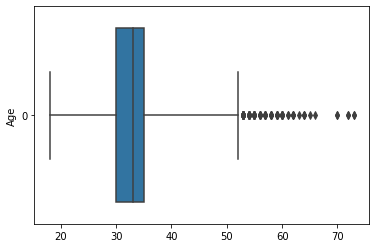

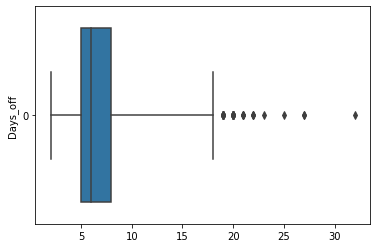

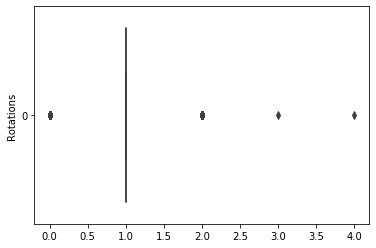

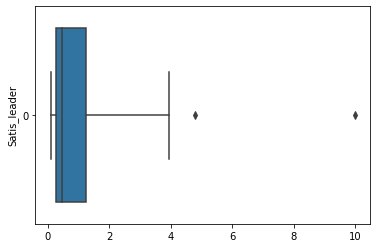

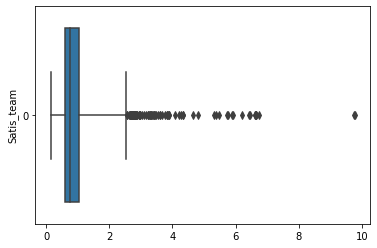

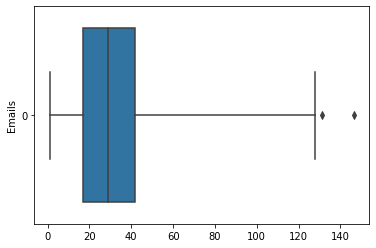

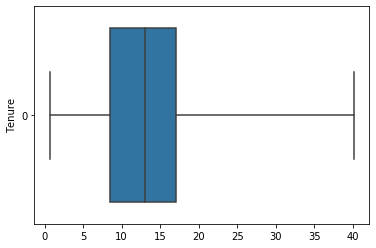

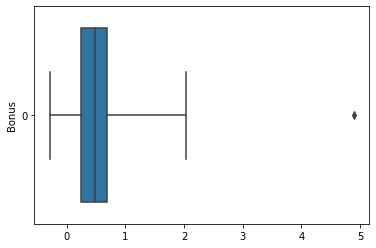

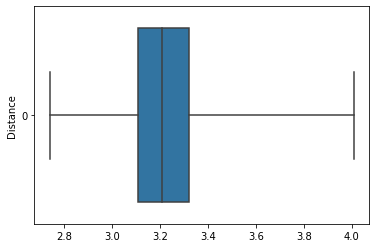

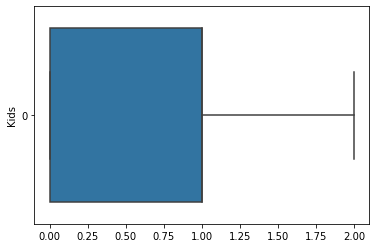

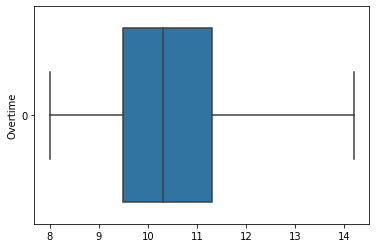

In [24]:
col = ['Age','Days_off','Rotations','Satis_leader','Satis_team','Emails','Tenure','Bonus','Distance','Kids','Overtime']

for c in col:
    sns.boxplot(data=data[c],orient='h',whis=3.5)
    plt.ylabel(c)
    plt.show()

There are a few outliers

In [25]:
def outliers(data, target, std=3, remove=False, pr=False):
    cols = []
    for col in ['Age','Days_off','Rotations','Satis_leader','Satis_team','Emails','Tenure','Bonus','Distance','Kids','Overtime']:
        if col in data.columns:
            cols.append(col)
    
    out = data[cols]
    out = pd.DataFrame(data=StandardScaler().fit_transform(out),index=out.index,columns=out.columns)
    
    ind = []
    for col in out.columns:
        ind_col = list(out[(out[col]<-std)|(out[col]>std)].index)
        ind += ind_col
        
    ind_to_remove = []
    for i in ind:
        if i not in ind_to_remove:
            ind_to_remove.append(i)
            
    if pr == True:
        print(len(ind_to_remove))
    
    if remove == True:
        for i in ind_to_remove:
            data = data.drop(i,0)
            target = target.drop(i,0)
        
        return data, target
            
    

In [26]:
outliers(data, target, pr=True)

360


In [27]:
outliers(data, target, std=4, pr=True)

121


Threshold:
* 3 standard deviations: 360 outliers (6.9% of the data)
* 4 standard deviations: 121 outliers (2.3% of the data)

These outliers can be ignored or removed.

## Feature Selection

In [28]:
data.columns

Index(['Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader', 'Satis_team',
       'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids', 'Overtime',
       'Marital_status', 'Department'],
      dtype='object')

In [29]:
data_cat = data[['Gender','Marital_status','Department']]
data_num = data.drop(['Gender','Marital_status','Department'],1)

In [30]:
anova = pd.DataFrame(data=np.transpose(f_classif(data_num,target)),index=data_num.columns,columns=['ANOVA','p_value']).sort_values(by='ANOVA',ascending=False)
anova

,ANOVA,p_value
Overtime,570.965076,6.997554e-225
Bonus,246.130673,7.425393e-103
Days_off,200.661931,1.134157e-84
Satis_team,98.461518,1.068941e-42
Rotations,53.804002,7.444649e-24
Age,15.806701,1.432294e-07
Emails,7.888850,3.794077e-04
Tenure,6.546814,1.446541e-03
Satis_leader,5.014155,6.675421e-03
Kids,4.939359,7.192834e-03


In [31]:
chi  = pd.DataFrame(data=np.transpose(chi2(data_cat,target)),index=data_cat.columns,columns=['chi2','p_value']).sort_values(by='chi2',ascending=False)
chi

,chi2,p_value
Gender,20.575061,0.000034
Marital_status,10.292082,0.005822
Department,3.164939,0.205467


In [32]:
mutual_info = pd.Series(index=data_cat.columns)
for col in data_cat.columns:
    mutual_info[col] = mutual_info_score(data_cat[col],target)
mutual_info.sort_values(ascending=False,inplace=True)
mutual_info

Gender            0.008090
Marital_status    0.003329
Department        0.001506
dtype: float64

Firstly, no features will be removed, and afterwards tests will be performed.

In [33]:
data.columns

Index(['Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader', 'Satis_team',
       'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids', 'Overtime',
       'Marital_status', 'Department'],
      dtype='object')

In [34]:
#data = data.drop(['Department','Marital_status','Distance','Kids','Gender'],1)

## Oversampling

Since the target variable is unbalanced, a hypothesis is to balance the dataset through oversampling. Undersampling was not considered because there's not much data to begin with.

In [35]:
def oversample(data, target):
    X = pd.concat([data, target], axis=1)  
    
    high = X[X.Churn_risk=='high']
    low = X[X.Churn_risk=='low']
    medium = X[X.Churn_risk=='medium']
    
    high_upsampled = resample(high,
                              replace=True, # sample with replacement
                              n_samples=len(medium), # match number in majority class
                              random_state=27) # reproducible results
    
    low_upsampled = resample(low,
                             replace=True, # sample with replacement
                             n_samples=len(medium), # match number in majority class
                             random_state=27) # reproducible results
    
    upsampled = pd.concat([high_upsampled, low_upsampled, medium])
    data = upsampled.drop(['Churn_risk'],1)
    target = upsampled['Churn_risk']
    
    return data, target

## Tuning Hyperparameters

In [36]:
def avg_score(model, method='mean', k=0, remove=False, oversampling=False, scaler=MinMaxScaler(), grid_search=False, parameters=None):
    # apply kfold
    kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    n_iter = []
    
    for train_index, test_index in kf.split(data,target):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # deal with the null values
        #print(method)
        X_train = null_values(X_train, method=method, k=k)
        X_test = null_values(X_test, method=method,k=k)
        
        # deal with outliers
        if remove == True:
            X_train, y_train = outliers(X_train, y_train, std=4, remove=remove)
        
        # oversample the minority class
        if oversampling == True:
            X_train, y_train = oversample(X_train, y_train)
        
        # scale the data
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # start counting time
        begin = time.perf_counter()
        
        # find the best hyperparameters
        if grid_search == True:
            clf = GridSearchCV(model,parameters,n_jobs=-1,scoring='f1_micro')
            clf.fit(X_train,y_train)
            model = clf.best_estimator_
            print(clf.best_params_)
            
        # fit the model to the data
        model.fit(X_train, y_train)
        
        # finish counting time
        end = time.perf_counter()
        
        # predictions
        Y_pred = model.predict(X_train)
        y_pred = model.predict(X_test)
        
        # check the mean f1-score for the train
        value_train = f1_score(y_train,Y_pred,average='micro')
        
        # check the mean f1-score for the test
        value_test = f1_score(y_test,y_pred,average='micro')
        
        # print a classification report and confusion matrix
        print(classification_report(y_true=y_test,y_pred=y_pred))
        print(confusion_matrix(y_true=y_test,y_pred=y_pred))
        
        # append the scores, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [37]:
def show_results(df, models, method = 'mean', k = 0, remove = False, oversampling = False, scaler = MinMaxScaler(), parameters = None):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for model in models:
        parameter_space = None
        if parameters != None:
            parameter_space = parameters[models.index(model)]
            
        if parameter_space == None:
            grid_search = False
        else:
            grid_search = True
                
        print('----------------------------------')
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(model, method = method, k = k, remove = remove, oversampling = oversampling, grid_search = grid_search, scaler = scaler, parameters = parameter_space)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
            
    return df

###  KNN

In [38]:
model_1 = KNeighborsClassifier(n_neighbors=1)
model_2 = KNeighborsClassifier(n_neighbors=2)
model_3 = KNeighborsClassifier(n_neighbors=3)
model_4 = KNeighborsClassifier(n_neighbors=4)
model_5 = KNeighborsClassifier(n_neighbors=5)
model_6 = KNeighborsClassifier(n_neighbors=6)
model_7 = KNeighborsClassifier(n_neighbors=7)
model_8 = KNeighborsClassifier(n_neighbors=8)
model_9 = KNeighborsClassifier(n_neighbors=9)
model_10 = KNeighborsClassifier(n_neighbors=10)

In [39]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(1,11))
show_results(df,[model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])

----------------------------------
              precision    recall  f1-score   support

        high       0.13      0.09      0.11        32
         low       0.57      0.56      0.56       382
      medium       0.70      0.72      0.71       626

    accuracy                           0.64      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.63      0.64      0.64      1040

[[  3   3  26]
 [  2 213 167]
 [ 18 160 448]]
              precision    recall  f1-score   support

        high       0.16      0.16      0.16        32
         low       0.57      0.55      0.56       382
      medium       0.70      0.72      0.71       626

    accuracy                           0.64      1040
   macro avg       0.48      0.47      0.48      1040
weighted avg       0.64      0.64      0.64      1040

[[  5   1  26]
 [  4 210 168]
 [ 22 155 449]]
              precision    recall  f1-score   support

        high       0.18      0.22      0.20        32
  

              precision    recall  f1-score   support

        high       0.35      0.18      0.24        33
         low       0.56      0.65      0.61       382
      medium       0.73      0.68      0.71       625

    accuracy                           0.65      1040
   macro avg       0.55      0.51      0.52      1040
weighted avg       0.66      0.65      0.65      1040

[[  6   4  23]
 [  0 249 133]
 [ 11 188 426]]
----------------------------------
              precision    recall  f1-score   support

        high       0.11      0.03      0.05        32
         low       0.63      0.55      0.58       382
      medium       0.71      0.79      0.75       626

    accuracy                           0.68      1040
   macro avg       0.48      0.46      0.46      1040
weighted avg       0.66      0.68      0.67      1040

[[  1   0  31]
 [  3 209 170]
 [  5 125 496]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.25      0.03      0.05        33
         low       0.63      0.62      0.62       381
      medium       0.73      0.78      0.75       626

    accuracy                           0.69      1040
   macro avg       0.54      0.47      0.48      1040
weighted avg       0.68      0.69      0.68      1040

[[  1   1  31]
 [  0 235 146]
 [  3 137 486]]
              precision    recall  f1-score   support

        high       0.25      0.03      0.05        33
         low       0.63      0.60      0.62       382
      medium       0.73      0.78      0.75       625

    accuracy                           0.69      1040
   macro avg       0.54      0.47      0.47      1040
weighted avg       0.68      0.69      0.68      1040

[[  1   0  32]
 [  0 230 152]
 [  3 135 487]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
1,0.038+/-0.01,1.0+/-0.0,0.639+/-0.01
2,0.043+/-0.01,0.83+/-0.0,0.593+/-0.01
3,0.046+/-0.01,0.813+/-0.0,0.65+/-0.01
4,0.054+/-0.01,0.781+/-0.0,0.657+/-0.01
5,0.036+/-0.01,0.77+/-0.01,0.677+/-0.01
6,0.035+/-0.01,0.763+/-0.0,0.675+/-0.01
7,0.045+/-0.01,0.757+/-0.01,0.685+/-0.01
8,0.051+/-0.02,0.75+/-0.0,0.689+/-0.0
9,0.041+/-0.01,0.748+/-0.0,0.685+/-0.01
10,0.044+/-0.01,0.745+/-0.0,0.686+/-0.01


Performs better with more neighbors.

In [40]:
model_10 = KNeighborsClassifier(n_neighbors=10)
model_20 = KNeighborsClassifier(n_neighbors=20)
model_30 = KNeighborsClassifier(n_neighbors=30)
model_40 = KNeighborsClassifier(n_neighbors=40)
model_50 = KNeighborsClassifier(n_neighbors=50)
model_60 = KNeighborsClassifier(n_neighbors=60)
model_70 = KNeighborsClassifier(n_neighbors=70)
model_80 = KNeighborsClassifier(n_neighbors=80)
model_90 = KNeighborsClassifier(n_neighbors=90)
model_100 = KNeighborsClassifier(n_neighbors=100)

In [41]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(10,110,10))
show_results(df,[model_10,model_20,model_30,model_40,model_50,model_60,model_70,model_80,model_90,model_100])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.62      0.62       382
      medium       0.73      0.76      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   0  32]
 [  1 236 145]
 [  1 148 477]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.61      0.61       382
      medium       0.73      0.77      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   2  30]
 [  1 233 148]
 [  2 141 483]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.70      0.54      0.61       382
      medium       0.72      0.86      0.78       625

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   1  32]
 [  0 208 174]
 [  0  89 536]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.51      0.58       382
      medium       0.71      0.85      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.45      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   1  31]
 [  0 195 187]
 [  0  97 529]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.39      0.49       381
      medium       0.68      0.90      0.77       626

    accuracy                           0.68      1040
   macro avg       0.46      0.43      0.42      1040
weighted avg       0.66      0.68      0.65      1040

[[  0   1  32]
 [  0 147 234]
 [  0  65 561]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.70      0.45      0.55       382
      medium       0.70      0.88      0.78       625

    accuracy                           0.70      1040
   macro avg       0.46      0.44      0.44      1040
weighted avg       0.67      0.70      0.67      1040

[[  0   1  32]
 [  0 172 210]
 [  0  73 552]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
10,0.038+/-0.0,0.745+/-0.0,0.686+/-0.01
20,0.039+/-0.0,0.726+/-0.01,0.698+/-0.01
30,0.043+/-0.01,0.72+/-0.01,0.697+/-0.01
40,0.045+/-0.01,0.714+/-0.01,0.694+/-0.01
50,0.046+/-0.01,0.707+/-0.0,0.695+/-0.01
60,0.04+/-0.01,0.706+/-0.0,0.69+/-0.01
70,0.042+/-0.01,0.701+/-0.0,0.686+/-0.01
80,0.049+/-0.0,0.696+/-0.0,0.68+/-0.01
90,0.042+/-0.0,0.69+/-0.0,0.68+/-0.01
100,0.047+/-0.01,0.688+/-0.0,0.676+/-0.01


Inconclusive

In [42]:
model_uniform = KNeighborsClassifier(weights='uniform')
model_distance = KNeighborsClassifier(weights='distance')

In [43]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['uniform','distance'])
show_results(df,[model_uniform,model_distance])

----------------------------------
              precision    recall  f1-score   support

        high       0.11      0.03      0.05        32
         low       0.63      0.55      0.58       382
      medium       0.71      0.79      0.75       626

    accuracy                           0.68      1040
   macro avg       0.48      0.46      0.46      1040
weighted avg       0.66      0.68      0.67      1040

[[  1   0  31]
 [  3 209 170]
 [  5 125 496]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.60       382
      medium       0.72      0.77      0.74       626

    accuracy                           0.68      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   0  32]
 [  1 225 156]
 [  5 140 481]]
              precision    recall  f1-score   support

        high       0.23      0.09      0.13        32
  

,Time,Train,Test
uniform,0.043+/-0.0,0.77+/-0.01,0.677+/-0.01
distance,0.045+/-0.01,1.0+/-0.0,0.689+/-0.01


The algorithm performs better with 'distance' weigths.

In [44]:
model_ball = KNeighborsClassifier(algorithm='ball_tree')
model_kd = KNeighborsClassifier(algorithm='kd_tree')
model_brute = KNeighborsClassifier(algorithm='brute')

In [45]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['ball tree','kd tree','brute-force'])
show_results(df,[model_ball,model_kd,model_brute])

----------------------------------
              precision    recall  f1-score   support

        high       0.11      0.03      0.05        32
         low       0.63      0.55      0.58       382
      medium       0.71      0.79      0.75       626

    accuracy                           0.68      1040
   macro avg       0.48      0.46      0.46      1040
weighted avg       0.66      0.68      0.67      1040

[[  1   0  31]
 [  3 209 170]
 [  5 125 496]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.60       382
      medium       0.72      0.77      0.74       626

    accuracy                           0.68      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   0  32]
 [  1 225 156]
 [  5 140 481]]
              precision    recall  f1-score   support

        high       0.23      0.09      0.13        32
  

,Time,Train,Test
ball tree,0.038+/-0.01,0.77+/-0.01,0.677+/-0.01
kd tree,0.054+/-0.01,0.77+/-0.01,0.677+/-0.01
brute-force,0.006+/-0.0,0.77+/-0.01,0.677+/-0.01


Inconclusive.

In [46]:
model_1 = KNeighborsClassifier(p=1)
model_2 = KNeighborsClassifier(p=2)
model_3 = KNeighborsClassifier(p=3)
model_cosine = KNeighborsClassifier(metric='cosine')

In [47]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=list(range(1,4))+['cosine'])
show_results(df,[model_1,model_2,model_3,model_cosine])

----------------------------------
              precision    recall  f1-score   support

        high       0.14      0.03      0.05        32
         low       0.65      0.57      0.61       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.70      1040
   macro avg       0.51      0.47      0.47      1040
weighted avg       0.68      0.70      0.68      1040

[[  1   0  31]
 [  1 219 162]
 [  5 118 503]]
              precision    recall  f1-score   support

        high       0.14      0.03      0.05        32
         low       0.63      0.59      0.61       382
      medium       0.72      0.78      0.75       626

    accuracy                           0.69      1040
   macro avg       0.50      0.47      0.47      1040
weighted avg       0.67      0.69      0.68      1040

[[  1   0  31]
 [  0 227 155]
 [  6 131 489]]
              precision    recall  f1-score   support

        high       0.29      0.12      0.17        32
  

              precision    recall  f1-score   support

        high       0.33      0.06      0.10        33
         low       0.64      0.55      0.59       382
      medium       0.72      0.80      0.76       625

    accuracy                           0.69      1040
   macro avg       0.56      0.47      0.48      1040
weighted avg       0.67      0.69      0.68      1040

[[  2   2  29]
 [  0 211 171]
 [  4 119 502]]


,Time,Train,Test
1,0.05+/-0.0,0.785+/-0.0,0.685+/-0.01
2,0.045+/-0.0,0.77+/-0.01,0.677+/-0.01
3,0.04+/-0.01,0.769+/-0.01,0.673+/-0.0
cosine,0.005+/-0.0,0.774+/-0.01,0.675+/-0.01


Manhattan distance performs the best.

### Logistic Regression

In [48]:
model_newton = LogisticRegression(solver='newton-cg')
model_lbfgs = LogisticRegression(solver='lbfgs')
model_liblinear = LogisticRegression(solver='liblinear')
model_sag = LogisticRegression(solver='sag')
model_saga = LogisticRegression(solver='saga')

In [49]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['newton-cg','lbfgs','liblinear','sag','saga'])
show_results(df,[model_newton,model_lbfgs,model_liblinear,model_sag,model_saga])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 212 170]
 [  0 100 525]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
newton-cg,0.236+/-0.03,0.71+/-0.0,0.709+/-0.01
lbfgs,0.252+/-0.03,0.71+/-0.0,0.709+/-0.01
liblinear,0.048+/-0.01,0.71+/-0.0,0.708+/-0.01
sag,0.082+/-0.02,0.71+/-0.0,0.709+/-0.01
saga,0.127+/-0.01,0.71+/-0.0,0.709+/-0.01


Inconclusive.

In [50]:
model_newton_l2 = LogisticRegression(penalty='l2',solver='newton-cg')
model_newton_none = LogisticRegression(penalty='none',solver='newton-cg')

In [51]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l2','none'])
show_results(df,[model_newton_l2,model_newton_none])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
l2,0.248+/-0.02,0.71+/-0.0,0.709+/-0.01
none,0.582+/-0.07,0.709+/-0.0,0.707+/-0.01


l2 performs best.

In [52]:
model_lbfgs_l2 = LogisticRegression(penalty='l2',solver='lbfgs')
model_lbfgs_none = LogisticRegression(penalty='none',solver='lbfgs')

In [53]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l2','none'])
show_results(df,[model_lbfgs_l2,model_lbfgs_none])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
l2,0.265+/-0.03,0.71+/-0.0,0.709+/-0.01
none,0.285+/-0.01,0.709+/-0.0,0.707+/-0.01


l2 performs best.

In [54]:
model_liblinear_l1 = LogisticRegression(penalty='l1',solver='liblinear')
model_liblinear_l2 = LogisticRegression(penalty='l2',solver='liblinear')

In [55]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l1','l2'])
show_results(df,[model_liblinear_l1,model_liblinear_l2])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 221 161]
 [  0 117 509]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
l1,0.305+/-0.04,0.71+/-0.0,0.707+/-0.01
l2,0.054+/-0.0,0.71+/-0.0,0.708+/-0.01


l2 performs best.

In [56]:
model_sag_l2 = LogisticRegression(penalty='l2',solver='sag')
model_sag_none = LogisticRegression(penalty='none',solver='sag')

In [57]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l2','none'])
show_results(df,[model_sag_l2,model_sag_none])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
l2,0.093+/-0.01,0.71+/-0.0,0.709+/-0.01
none,0.258+/-0.04,0.709+/-0.0,0.707+/-0.01


l2 performs best.

In [58]:
model_saga_elasticnet_0_9 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.9)
model_saga_elasticnet_0_8 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.8)
model_saga_elasticnet_0_7 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.7)
model_saga_elasticnet_0_6 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.6)
model_saga_elasticnet_0_5 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5)
model_saga_elasticnet_0_4 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.4)
model_saga_elasticnet_0_3 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.3)
model_saga_elasticnet_0_2 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.2)
model_saga_elasticnet_0_1 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.1)

In [59]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=[0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1])
show_results(df,[model_saga_elasticnet_0_9,model_saga_elasticnet_0_8,model_saga_elasticnet_0_7,model_saga_elasticnet_0_6,model_saga_elasticnet_0_5,model_saga_elasticnet_0_4,model_saga_elasticnet_0_3,model_saga_elasticnet_0_2,model_saga_elasticnet_0_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 237 145]
 [  0 111 515]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 221 161]
 [  0 113 513]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.61       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 212 170]
 [  0 101 524]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 111 515]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 214 167]
 [  0  98 528]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.61       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 211 171]
 [  0 101 524]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
0.9,0.26+/-0.04,0.711+/-0.0,0.708+/-0.01
0.8,0.421+/-0.07,0.711+/-0.0,0.708+/-0.01
0.7,0.303+/-0.02,0.711+/-0.0,0.708+/-0.01
0.6,0.237+/-0.02,0.711+/-0.0,0.709+/-0.01
0.5,0.195+/-0.02,0.71+/-0.0,0.708+/-0.01
0.4,0.145+/-0.04,0.71+/-0.0,0.708+/-0.01
0.3,0.148+/-0.01,0.71+/-0.0,0.708+/-0.01
0.2,0.162+/-0.03,0.71+/-0.0,0.708+/-0.01
0.1,0.174+/-0.02,0.71+/-0.0,0.708+/-0.01


Inconclusive.

In [70]:
model_saga_l1 = LogisticRegression(penalty='l1',solver='saga')
model_saga_l2 = LogisticRegression(penalty='l2',solver='saga')
model_saga_elasticnet_0_5 = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5)
model_saga_none = LogisticRegression(penalty='none',solver='saga')

In [71]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['l1','l2','elasticnet','none'])
show_results(df,[model_saga_l1,model_saga_l2,model_saga_elasticnet_0_9,model_saga_none])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 238 144]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 223 159]
 [  0 113 513]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 209 173]
 [  0 105 520]]


,Time,Train,Test
l1,0.217+/-0.03,0.711+/-0.0,0.708+/-0.01
l2,0.103+/-0.01,0.71+/-0.0,0.709+/-0.01
elasticnet,0.238+/-0.02,0.711+/-0.0,0.708+/-0.01
none,0.356+/-0.02,0.71+/-0.0,0.708+/-0.01


l2 performs best.

In [62]:
model_0 = LogisticRegression(fit_intercept=False)
model_1 = LogisticRegression(fit_intercept=True)

In [63]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no intercept','intercept'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.65       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 234 148]
 [  0 106 520]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 109 517]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
no intercept,0.217+/-0.03,0.71+/-0.0,0.709+/-0.01
intercept,0.221+/-0.01,0.71+/-0.0,0.709+/-0.01


Inconclusive.

In [64]:
model_0 = LogisticRegression(class_weight=None)
model_1 = LogisticRegression(class_weight='balanced')

In [65]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['not balanced','balanced'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
not balanced,0.259+/-0.01,0.71+/-0.0,0.709+/-0.01
balanced,0.234+/-0.05,0.52+/-0.0,0.517+/-0.02


Better when it's not balanced.

In [66]:
model_auto = LogisticRegression(multi_class='auto')
model_ovr = LogisticRegression(multi_class='ovr')
model_multinomial = LogisticRegression(multi_class='multinomial')

In [67]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['auto','ovr','multinomial'])
show_results(df,[model_auto,model_ovr,model_multinomial])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
auto,0.233+/-0.03,0.71+/-0.0,0.709+/-0.01
ovr,0.203+/-0.04,0.71+/-0.0,0.707+/-0.01
multinomial,0.241+/-0.04,0.71+/-0.0,0.709+/-0.01


auto and multinomial perform better.

In [68]:
model_0 = LogisticRegression(warm_start=False)
model_1 = LogisticRegression(warm_start=True)

In [69]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no warm start','warm start'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
no warm start,0.273+/-0.03,0.71+/-0.0,0.709+/-0.01
warm start,0.247+/-0.05,0.71+/-0.0,0.709+/-0.01


Inconclusive.

## Ridge Classifier

In [72]:
model_0 = RidgeClassifier(fit_intercept=False)
model_1 = RidgeClassifier(fit_intercept=True)

In [73]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['no intercept','intercept'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 211 171]
 [  0 109 517]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
no intercept,0.016+/-0.01,0.709+/-0.0,0.704+/-0.01
intercept,0.016+/-0.0,0.709+/-0.0,0.705+/-0.01


Inconclusive.

In [74]:
model_0 = RidgeClassifier(max_iter=None)
model_1 = RidgeClassifier(max_iter=1)
model_2 = RidgeClassifier(max_iter=2)
model_3 = RidgeClassifier(max_iter=3)
model_4 = RidgeClassifier(max_iter=4)
model_5 = RidgeClassifier(max_iter=5)
model_6 = RidgeClassifier(max_iter=6)
model_7 = RidgeClassifier(max_iter=7)
model_8 = RidgeClassifier(max_iter=8)
model_9 = RidgeClassifier(max_iter=9)
model_10 = RidgeClassifier(max_iter=10)

In [75]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=range(0,11))
show_results(df,[model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.55      0.60       382
      medium       0.72      0.82      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 212 170]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   2  31]
 [  0 206 176]
 [  0  98 527]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0  99 527]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   2  31]
 [  0 206 176]
 [  0  98 527]]
----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
0,0.014+/-0.0,0.709+/-0.0,0.705+/-0.01
1,0.018+/-0.0,0.709+/-0.0,0.705+/-0.01
2,0.02+/-0.0,0.709+/-0.0,0.705+/-0.01
3,0.022+/-0.0,0.709+/-0.0,0.705+/-0.01
4,0.015+/-0.0,0.709+/-0.0,0.705+/-0.01
5,0.022+/-0.0,0.709+/-0.0,0.705+/-0.01
6,0.02+/-0.01,0.709+/-0.0,0.705+/-0.01
7,0.021+/-0.0,0.709+/-0.0,0.705+/-0.01
8,0.02+/-0.01,0.709+/-0.0,0.705+/-0.01
9,0.021+/-0.0,0.709+/-0.0,0.705+/-0.01


Inconclusive.

In [76]:
model_0 = RidgeClassifier(class_weight=None)
model_1 = RidgeClassifier(class_weight='balanced')

In [77]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['not balanced','balanced'])
show_results(df,[model_0,model_1])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.55      0.60       382
      medium       0.72      0.82      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 212 170]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
not balanced,0.018+/-0.0,0.709+/-0.0,0.705+/-0.01
balanced,0.022+/-0.01,0.457+/-0.0,0.454+/-0.02


Not balanced performs better.

In [78]:
model_auto = RidgeClassifier(solver='auto')
model_svd = RidgeClassifier(solver='svd')
model_cholesky = RidgeClassifier(solver='cholesky')
model_lsqr = RidgeClassifier(solver='lsqr')
model_sparse_cg = RidgeClassifier(solver='sparse_cg')
model_sag = RidgeClassifier(solver='sag')
model_saga = RidgeClassifier(solver='saga')

In [79]:
df = pd.DataFrame(columns=['Time','Train','Test'],index=['auto','svd','cholesky','lsqr','sparse_cg','sag','saga'])
show_results(df,[model_auto,model_svd,model_cholesky,model_lsqr,model_sparse_cg,model_sag,model_saga])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.55      0.60       382
      medium       0.72      0.82      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 212 170]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 112 514]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.55      0.60       382
      medium       0.72      0.82      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 212 170]
 [  0 114 512]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56    

,Time,Train,Test
auto,0.019+/-0.0,0.709+/-0.0,0.705+/-0.01
svd,0.02+/-0.0,0.709+/-0.0,0.705+/-0.01
cholesky,0.015+/-0.0,0.709+/-0.0,0.705+/-0.01
lsqr,0.04+/-0.01,0.709+/-0.0,0.706+/-0.01
sparse_cg,0.053+/-0.01,0.709+/-0.0,0.705+/-0.01
sag,0.092+/-0.02,0.709+/-0.0,0.705+/-0.01
saga,0.08+/-0.03,0.709+/-0.0,0.705+/-0.01


Inconclusive.

In [80]:
parameter_space_knn = {
    'n_neighbors':[10,20,30,40,50,60,70,80,90,100],
    'weights':['distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'p':[1],
}
parameter_space_lr = {
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty':['l2'],
    'fit_intercept':[True,False],
    'multi_class':['multinomial','auto'],
    'warm_start':[True,False]
}
parameter_space_rc = {
    'fit_intercept':[True,False],
    'max_iter':[None,1,2,3,4,5,6,7,8,9,10],
    'solver':['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']
}
model_knn = KNeighborsClassifier()
model_nb = GaussianNB()
model_lr = LogisticRegression()
model_rc = RidgeClassifier()

## Tests

### Data Cleaning and Scaling

Given that there are so many alternatives on how to clean and scale the data, they're going to be tested against each other.

In [81]:
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn','nb','lr','rc'])
show_results(df,[model_knn, model_nb, model_lr, model_rc], parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.70      0.46      0.55       382
      medium       0.70      0.88      0.78       626

    accuracy                           0.70      1040
   macro avg       0.47      0.45      0.44      1040
weighted avg       0.68      0.70      0.67      1040

[[  0   0  32]
 [  0 175 207]
 [  0  75 551]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 100 526]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,6.166+/-1.6,1.0+/-0.0,0.722+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.35+/-0.56,0.71+/-0.0,0.708+/-0.01
rc,7.543+/-0.88,0.707+/-0.0,0.708+/-0.01


In [82]:
show_results(df,[model_knn, model_nb, model_lr, model_rc],scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 219 163]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 216 165]
 [  0  99 527]]
{'fit_intercept': True, 'max_iter'

,Time,Train,Test
knn,6.889+/-0.83,1.0+/-0.0,0.741+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.588+/-0.34,0.709+/-0.0,0.706+/-0.01
rc,6.487+/-0.35,0.709+/-0.0,0.707+/-0.01


In [83]:
show_results(df,[model_knn, model_nb, model_lr, model_rc],scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  28]
 [  0 219 163]
 [  0 109 517]]
{'fit_intercept': False, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.62      0.64       381
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 237 144]
 [  1 121 504]]
{'fit_intercept': False, 'max_ite

,Time,Train,Test
knn,6.105+/-0.33,1.0+/-0.0,0.747+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,9.647+/-0.33,0.709+/-0.0,0.708+/-0.01
rc,6.316+/-0.28,0.708+/-0.0,0.71+/-0.01


In [84]:
show_results(df,[model_knn, model_nb, model_lr, model_rc],scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 219 163]
 [  0 125 501]]
{'fit_intercept': False, 'max_iter': 9, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   2  31]
 [  0 209 172]
 [  0  91 535]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,5.484+/-0.23,1.0+/-0.0,0.71+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.548+/-0.48,0.71+/-0.0,0.708+/-0.01
rc,6.924+/-0.35,0.71+/-0.0,0.708+/-0.01


In [85]:
show_results(df,[model_knn, model_nb, model_lr, model_rc],remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 222 160]
 [  0 122 504]]
{'fit_intercept': False, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.70      0.48      0.57       381
      medium       0.71      0.88      0.78       626

    accuracy                           0.70      1040
   macro avg       0.47      0.45      0.45      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   2  31]
 [  0 183 198]
 [  0  77 549]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,5.773+/-0.27,1.0+/-0.0,0.723+/-0.0
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.089+/-0.52,0.712+/-0.0,0.708+/-0.01
rc,6.415+/-0.54,0.712+/-0.0,0.705+/-0.01


In [86]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   3  29]
 [  0 219 163]
 [  0 128 498]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 215 166]
 [  0 100 526]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,5.775+/-0.15,1.0+/-0.0,0.737+/-0.0
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,5.703+/-0.17,0.713+/-0.0,0.709+/-0.01
rc,6.582+/-0.29,0.708+/-0.0,0.705+/-0.01


In [87]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 7, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 223 159]
 [  3 126 497]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,5.559+/-0.26,1.0+/-0.0,0.745+/-0.01
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.205+/-0.36,0.712+/-0.0,0.709+/-0.01
rc,6.835+/-0.33,0.711+/-0.0,0.706+/-0.01


In [88]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 5, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,5.411+/-0.23,1.0+/-0.0,0.715+/-0.01
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,8.043+/-0.48,0.713+/-0.0,0.708+/-0.01
rc,7.002+/-0.42,0.714+/-0.0,0.707+/-0.01


In [89]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 211 171]
 [  0 118 508]]
{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.54      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 207 174]
 [  0  92 534]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,5.875+/-0.32,1.0+/-0.0,0.722+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,6.776+/-0.13,0.711+/-0.0,0.708+/-0.01
rc,7.028+/-0.21,0.709+/-0.0,0.707+/-0.01


In [90]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.58      0.60       382
      medium       0.72      0.78      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 223 159]
 [  0 136 490]]
{'fit_intercept': True, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.58      0.62       381
      medium       0.74      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 220 161]
 [  0  99 527]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,6.331+/-0.24,1.0+/-0.0,0.741+/-0.01
nb,0.007+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.69+/-0.27,0.709+/-0.0,0.706+/-0.01
rc,6.743+/-0.17,0.71+/-0.0,0.706+/-0.01


In [91]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 221 161]
 [  0 125 501]]
{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 217 164]
 [  0 101 525]]
{'fit_intercept': False, 'max_iter

,Time,Train,Test
knn,6.086+/-0.19,1.0+/-0.0,0.747+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,10.632+/-0.63,0.709+/-0.0,0.708+/-0.01
rc,7.008+/-0.31,0.711+/-0.0,0.705+/-0.01


In [92]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 218 164]
 [  0 128 498]]
{'fit_intercept': False, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 208 173]
 [  0  91 535]]
{'fit_intercept': True,

,Time,Train,Test
knn,5.48+/-0.28,1.0+/-0.0,0.71+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.31+/-0.16,0.71+/-0.0,0.708+/-0.01
rc,6.691+/-0.15,0.711+/-0.0,0.706+/-0.01


In [93]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 223 159]
 [  0 130 496]]
{'fit_intercept': False, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.61      0.63       381
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 232 149]
 [  0 114 512]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,5.858+/-0.23,1.0+/-0.0,0.723+/-0.0
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.074+/-0.13,0.712+/-0.0,0.708+/-0.01
rc,6.532+/-0.25,0.712+/-0.0,0.706+/-0.01


In [94]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 222 160]
 [  0 130 496]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.53      0.60       381
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   1  32]
 [  0 202 179]
 [  0  88 538]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,6.913+/-1.28,1.0+/-0.0,0.737+/-0.0
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,6.466+/-0.34,0.713+/-0.0,0.709+/-0.01
rc,6.646+/-0.11,0.711+/-0.0,0.705+/-0.01


In [95]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 1, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.54      0.60       382
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 206 176]
 [  0  95 531]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,5.743+/-0.1,1.0+/-0.0,0.745+/-0.01
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.602+/-0.26,0.713+/-0.0,0.709+/-0.01
rc,6.482+/-0.12,0.712+/-0.0,0.712+/-0.01


In [96]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='median', remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,5.396+/-0.18,1.0+/-0.0,0.715+/-0.01
nb,0.006+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.668+/-0.33,0.713+/-0.0,0.708+/-0.01
rc,6.913+/-0.37,0.714+/-0.0,0.705+/-0.01


In [97]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 216 166]
 [  0 120 506]]
{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.54      0.60       381
      medium       0.72      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 207 174]
 [  0  98 528]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,6.275+/-0.81,1.0+/-0.0,0.722+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.039+/-0.19,0.71+/-0.0,0.708+/-0.01
rc,7.009+/-0.13,0.71+/-0.0,0.703+/-0.01


In [98]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 215 167]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.58      0.62       381
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 220 161]
 [  0 104 522]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,6.332+/-0.27,1.0+/-0.0,0.741+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.99+/-0.44,0.709+/-0.0,0.706+/-0.01
rc,6.893+/-0.28,0.709+/-0.0,0.706+/-0.01


In [99]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 221 161]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 216 165]
 [  0  98 528]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,6.319+/-0.31,1.0+/-0.0,0.747+/-0.01
nb,0.007+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,10.382+/-0.22,0.709+/-0.0,0.708+/-0.01
rc,7.654+/-0.52,0.71+/-0.0,0.707+/-0.01


In [100]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 216 166]
 [  0 119 507]]
{'fit_intercept': False, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 208 173]
 [  0  91 535]]
{'fit_intercept': False

,Time,Train,Test
knn,5.686+/-0.42,1.0+/-0.0,0.71+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.401+/-0.29,0.71+/-0.0,0.708+/-0.01
rc,7.004+/-0.11,0.711+/-0.0,0.711+/-0.01


In [101]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 124 502]]
{'fit_intercept': False, 'max_iter': 5, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 219 162]
 [  0 103 523]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,5.897+/-0.15,1.0+/-0.0,0.723+/-0.0
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,6.87+/-0.18,0.712+/-0.0,0.708+/-0.01
rc,6.623+/-0.14,0.712+/-0.0,0.706+/-0.01


In [102]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.57      0.59       382
      medium       0.72      0.79      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 216 166]
 [  0 129 497]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 214 167]
 [  0 102 524]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,6.075+/-0.38,1.0+/-0.0,0.737+/-0.0
nb,0.005+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,6.126+/-0.21,0.713+/-0.0,0.709+/-0.01
rc,7.003+/-0.61,0.711+/-0.0,0.704+/-0.01


In [103]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 5, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   3  29]
 [  0 217 165]
 [  0 126 500]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,5.842+/-0.2,1.0+/-0.0,0.745+/-0.01
nb,0.006+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.61+/-0.15,0.713+/-0.0,0.709+/-0.01
rc,6.553+/-0.13,0.712+/-0.01,0.708+/-0.01


In [104]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=1, remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.56      0.58       382
      medium       0.71      0.78      0.75       626

    accuracy                           0.68      1040
   macro avg       0.44      0.45      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   4  28]
 [  0 215 167]
 [  0 138 488]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,5.443+/-0.12,1.0+/-0.0,0.715+/-0.01
nb,0.006+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.765+/-0.21,0.713+/-0.0,0.708+/-0.01
rc,6.809+/-0.22,0.712+/-0.01,0.704+/-0.02


In [105]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.64      0.62       382
      medium       0.74      0.74      0.74       626

    accuracy                           0.68      1040
   macro avg       0.44      0.46      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   4  28]
 [  0 246 136]
 [  0 163 463]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   4  29]
 [  0 213 168]
 [  0  99 527]]
{'fit_intercept': False, 'max_ite

,Time,Train,Test
knn,5.997+/-0.2,1.0+/-0.0,0.722+/-0.01
nb,0.006+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,6.795+/-0.27,0.71+/-0.0,0.708+/-0.01
rc,7.354+/-0.59,0.709+/-0.0,0.705+/-0.01


In [106]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 227 155]
 [  0 127 499]]
{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 216 165]
 [  0  99 527]]
{'fit_intercept': True, 'max_iter'

,Time,Train,Test
knn,6.884+/-0.49,1.0+/-0.0,0.741+/-0.01
nb,0.01+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.495+/-0.86,0.709+/-0.0,0.706+/-0.01
rc,9.128+/-1.17,0.708+/-0.0,0.707+/-0.01


In [107]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.61       382
      medium       0.73      0.78      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 226 156]
 [  0 135 491]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.60      0.62       381
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 230 151]
 [  1 121 504]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,8.647+/-0.62,1.0+/-0.0,0.747+/-0.01
nb,0.007+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,13.566+/-1.04,0.709+/-0.0,0.708+/-0.01
rc,7.727+/-0.38,0.709+/-0.0,0.703+/-0.01


In [108]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 


[[  0   0  32]
 [  0 212 170]
 [  0 101 525]]
{'fit_intercept': False, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   1  31]
 [  0 224 158]
 [  0 108 518]]
{'fit_intercept': False, 'max_iter': 8, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 208 173]


,Time,Train,Test
knn,6.872+/-0.41,1.0+/-0.0,0.71+/-0.01
nb,0.01+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.853+/-0.55,0.71+/-0.0,0.707+/-0.01
rc,7.852+/-0.76,0.71+/-0.0,0.712+/-0.0


In [109]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 5, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.63      0.61       382
      medium       0.74      0.75      0.74       626

    accuracy                           0.68      1040
   macro avg       0.44      0.46      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   5  27]
 [  0 241 141]
 [  0 159 467]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.61       381
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 217 164]
 [  0 104 522]]
{'fit_intercept': False, 'max_ite

,Time,Train,Test
knn,7.923+/-0.6,1.0+/-0.0,0.723+/-0.0
nb,0.01+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.681+/-0.79,0.712+/-0.0,0.708+/-0.01
rc,8.52+/-0.45,0.712+/-0.0,0.703+/-0.01


In [110]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   3  29]
 [  0 212 170]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 219 162]
 [  0 105 521]]
{'fit_intercept': True, 'max_iter'

,Time,Train,Test
knn,7.016+/-0.56,1.0+/-0.0,0.737+/-0.0
nb,0.011+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.537+/-0.68,0.713+/-0.0,0.709+/-0.01
rc,7.921+/-0.43,0.711+/-0.0,0.708+/-0.01


In [111]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 121 505]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,7.282+/-0.31,1.0+/-0.0,0.745+/-0.01
nb,0.01+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.733+/-0.98,0.713+/-0.0,0.709+/-0.01
rc,8.399+/-0.88,0.712+/-0.0,0.709+/-0.01


In [112]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=2, remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 


[[  0   0  32]
 [  0 213 169]
 [  0 105 521]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 

,Time,Train,Test
knn,6.733+/-0.7,1.0+/-0.0,0.715+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.029+/-0.31,0.713+/-0.0,0.708+/-0.01
rc,9.06+/-0.68,0.713+/-0.0,0.708+/-0.01


In [113]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 210 172]
 [  0 119 507]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.56      0.61       381
      medium       0.73      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   4  29]
 [  0 213 168]
 [  0 106 520]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,7.352+/-0.61,1.0+/-0.0,0.722+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.524+/-0.34,0.711+/-0.0,0.708+/-0.01
rc,8.098+/-0.43,0.708+/-0.0,0.703+/-0.01


In [114]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.56      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 214 168]
 [  0 126 500]]
{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   1  32]
 [  0 210 171]
 [  0  97 529]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,8.088+/-0.88,1.0+/-0.0,0.741+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,9.385+/-1.02,0.709+/-0.0,0.706+/-0.01
rc,8.471+/-0.47,0.708+/-0.0,0.704+/-0.01


In [115]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.61       382
      medium       0.73      0.78      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 227 155]
 [  0 135 491]]
{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 216 165]
 [  0  99 527]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,8.427+/-1.16,1.0+/-0.0,0.747+/-0.01
nb,0.007+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,12.723+/-0.71,0.709+/-0.0,0.708+/-0.01
rc,9.247+/-0.8,0.71+/-0.0,0.706+/-0.01


In [116]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.56      0.60       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   4  28]
 [  0 214 168]
 [  0 110 516]]
{'fit_intercept': False, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.57      0.62       381
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 219 162]
 [  0 110 516]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,7.471+/-0.59,1.0+/-0.0,0.71+/-0.01
nb,0.01+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.677+/-0.14,0.71+/-0.0,0.708+/-0.01
rc,7.961+/-0.29,0.71+/-0.0,0.707+/-0.0


In [117]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 222 160]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 5, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 100 526]]
{'fit_intercept': False, 'max_i

,Time,Train,Test
knn,5.967+/-0.3,1.0+/-0.0,0.723+/-0.0
nb,0.011+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.583+/-0.64,0.712+/-0.0,0.708+/-0.01
rc,6.456+/-0.21,0.712+/-0.0,0.706+/-0.01


In [118]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 219 163]
 [  0 123 503]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 103 523]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,6.105+/-0.26,1.0+/-0.0,0.737+/-0.0
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,6.815+/-0.4,0.713+/-0.0,0.709+/-0.01
rc,6.647+/-0.23,0.711+/-0.0,0.708+/-0.01


In [119]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 125 501]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': True, 'max_it

,Time,Train,Test
knn,6.54+/-0.28,1.0+/-0.0,0.745+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,8.916+/-0.34,0.713+/-0.0,0.709+/-0.01
rc,8.195+/-0.48,0.712+/-0.0,0.706+/-0.01


In [120]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=3, remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 121 505]]
{'fit_intercept': False, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.61      0.68      0.64       381
      medium       0.75      0.75      0.75       626

    accuracy                           0.70      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   4  29]
 [  0 258 123]
 [  0 158 468]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,6.909+/-0.53,1.0+/-0.0,0.715+/-0.01
nb,0.007+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.311+/-0.49,0.713+/-0.0,0.706+/-0.01
rc,7.756+/-0.29,0.711+/-0.0,0.704+/-0.01


In [121]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': True, 'max_iter': 5, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 214 168]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 219 162]
 [  0  99 527]]
{'fit_intercept': False, 'max_ite

,Time,Train,Test
knn,6.947+/-0.43,1.0+/-0.0,0.722+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.874+/-0.45,0.711+/-0.0,0.708+/-0.01
rc,8.02+/-0.36,0.709+/-0.0,0.707+/-0.01


In [122]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.54      0.58       382
      medium       0.71      0.81      0.75       626

    accuracy                           0.68      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   0  32]
 [  0 207 175]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 219 162]
 [  0 100 526]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,7.666+/-0.27,1.0+/-0.0,0.741+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,9.558+/-0.61,0.709+/-0.0,0.706+/-0.01
rc,8.491+/-0.21,0.71+/-0.0,0.705+/-0.01


In [123]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 5, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 226 156]
 [  0 133 493]]
{'fit_intercept': True, 'max_iter': 5, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.58      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 220 161]
 [  0 102 524]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,7.293+/-0.4,1.0+/-0.0,0.747+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,12.155+/-0.35,0.709+/-0.0,0.708+/-0.01
rc,8.537+/-0.35,0.709+/-0.0,0.705+/-0.01


In [124]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 218 164]
 [  0 128 498]]
{'fit_intercept': False, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 208 173]
 [  0  91 535]]
{'fit_intercept': True,

,Time,Train,Test
knn,6.625+/-0.31,1.0+/-0.0,0.71+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.86+/-0.37,0.71+/-0.0,0.708+/-0.01
rc,8.769+/-0.62,0.712+/-0.0,0.706+/-0.01


In [125]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 212 170]
 [  0 120 506]]
{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 225 156]
 [  0 109 517]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,6.978+/-0.24,1.0+/-0.0,0.723+/-0.0
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,8.152+/-0.34,0.712+/-0.0,0.708+/-0.01
rc,8.056+/-0.23,0.711+/-0.0,0.705+/-0.01


In [126]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 219 163]
 [  0 119 507]]
{'fit_intercept': True, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   4  29]
 [  0 215 166]
 [  0 101 525]]
{'fit_intercept': True, 'max_ite

,Time,Train,Test
knn,6.974+/-0.22,1.0+/-0.0,0.737+/-0.0
nb,0.009+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.436+/-0.25,0.713+/-0.0,0.709+/-0.01
rc,7.914+/-0.33,0.712+/-0.0,0.706+/-0.01


In [127]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 2, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   3  29]
 [  0 212 170]
 [  0 124 502]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,6.918+/-0.28,1.0+/-0.0,0.745+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.266+/-0.71,0.713+/-0.0,0.709+/-0.01
rc,7.894+/-0.18,0.709+/-0.01,0.705+/-0.01


In [128]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=4, remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,6.549+/-0.16,1.0+/-0.0,0.715+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.311+/-0.34,0.714+/-0.0,0.707+/-0.01
rc,7.945+/-0.31,0.715+/-0.0,0.708+/-0.01


In [129]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.55      0.62       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[ 

{'fit_intercept': False, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.68      0.64       382
      medium       0.75      0.73      0.74       626

    accuracy                           0.69      1040
   macro avg       0.45      0.47      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 259 123]
 [  0 166 460]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 214 167]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,7.128+/-0.35,1.0+/-0.0,0.722+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.971+/-0.31,0.711+/-0.0,0.708+/-0.01
rc,9.302+/-0.59,0.709+/-0.0,0.705+/-0.01


In [130]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.62      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.51      1040
weighted avg       0.76      0.75      0.74      1040

[[  1   0  31]
 [  0 235 147]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[ 

{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 123 503]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 217 164]
 [  0  99 527]]
{'fit_intercept': True, 'max_iter

,Time,Train,Test
knn,7.068+/-0.74,1.0+/-0.0,0.741+/-0.01
nb,0.009+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,7.488+/-0.49,0.709+/-0.0,0.706+/-0.01
rc,6.835+/-0.25,0.709+/-0.0,0.709+/-0.01


In [131]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.63      0.69       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 242 140]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.62      0.65       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.73      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 5, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 226 156]
 [  0 132 494]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.60      0.62       381
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 230 151]
 [  1 121 504]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,5.984+/-0.47,1.0+/-0.0,0.747+/-0.01
nb,0.008+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,12.07+/-0.44,0.709+/-0.0,0.708+/-0.01
rc,8.44+/-0.47,0.711+/-0.0,0.704+/-0.01


In [132]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 5, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 217 165]
 [  0 118 508]]
{'fit_intercept': False, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.55      0.61       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 208 173]
 [  0  91 535]]
{'fit_intercept': True, 

,Time,Train,Test
knn,6.737+/-0.43,1.0+/-0.0,0.71+/-0.01
nb,0.01+/-0.0,0.599+/-0.02,0.594+/-0.04
lr,8.987+/-0.49,0.71+/-0.0,0.708+/-0.01
rc,8.155+/-0.19,0.711+/-0.0,0.708+/-0.01


In [133]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 221 161]
 [  0  94 532]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.56      0.62       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.53      1040
weighted avg       0.73      0.72      0.71      1040

[[ 

{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.58      0.62       381
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 220 161]
 [  0 106 520]]
{'fit_intercept': False, 'max_ite

,Time,Train,Test
knn,7.072+/-0.18,1.0+/-0.0,0.723+/-0.0
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,8.289+/-0.17,0.712+/-0.0,0.708+/-0.01
rc,7.837+/-0.37,0.711+/-0.0,0.707+/-0.01


In [134]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, remove=True, scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.62      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 235 147]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[ 

 [  0  98 528]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 215 167]
 [  0 124 502]]
{'fit_intercept': True, 'max_iter': 1, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.53      0.60       381
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   1  32]
 [  0 201 180]
 [  0  88 538]]
{'fit_intercept':

,Time,Train,Test
knn,6.901+/-0.22,1.0+/-0.0,0.737+/-0.0
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,7.419+/-0.26,0.713+/-0.0,0.709+/-0.01
rc,8.723+/-0.52,0.709+/-0.0,0.706+/-0.01


In [135]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, remove=True, scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.63      0.69       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.77      0.76      0.75      1040

[[  3   0  29]
 [  0 241 141]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[ 

{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 225 157]
 [  3 128 495]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  1 226 154]
 [  1 107 518]]
{'fit_intercept': False, 'max_

,Time,Train,Test
knn,6.861+/-0.3,1.0+/-0.0,0.745+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,8.868+/-0.16,0.713+/-0.0,0.709+/-0.01
rc,7.937+/-0.24,0.714+/-0.0,0.707+/-0.01


In [136]:
show_results(df,[model_knn, model_nb, model_lr, model_rc], method='knn', k=5, remove=True, scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.55      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[ 

{'fit_intercept': True, 'max_iter': 9, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 219 163]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 217 164]
 [  0 103 523]]
{'fit_intercept': False, 'max_it

,Time,Train,Test
knn,6.369+/-0.19,1.0+/-0.0,0.715+/-0.01
nb,0.008+/-0.0,0.599+/-0.01,0.596+/-0.03
lr,9.067+/-0.36,0.713+/-0.0,0.708+/-0.01
rc,7.925+/-0.29,0.714+/-0.0,0.706+/-0.01


After running the algorithms using different ways to replace null values, different scalers, and choosing to remove or not the outliers, the following results were obtained:

![alt text](knn_results_.png "KNN results")

![alt text](nb_results_.png "Gaussian NB results")

![alt text](lr_results_.png "Logistic Regression results")

![alt text](rc_results_.png "Ridge Classifier results")

It appears that the way to replace nulls has no influence in the f1_score of the algorithm, so we're choosing the simplest way to replace null values: using the mean.

### Feature Selection

Even though the correlation between the independent variables and the target variable was evaluated above, here the evaluation will be done by looking at how removing each feature affects the f1_score of the model.

In [137]:
cat_cols = ['Gender','Marital_status','Department']
num_cols = ['Age','Days_off','Rotations','Satis_leader','Satis_team','Emails','Tenure','Bonus','Distance','Kids','Overtime']
data_ = data

In [138]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.59      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.49      0.50      1040
weighted avg       0.74      0.73      0.71      1040

[[  1   0  31]
 [  0 225 157]
 [  0  93 533]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.56      0.63       382
      medium       0.74      0.87      0.80       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      10

{'fit_intercept': False, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.54      0.59       382
      medium       0.72      0.82      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.67      0.69      0.67      1040

[[  0   4  28]
 [  0 208 174]
 [  0 115 511]]
{'fit_intercept': False, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 226 155]
 [  0 105 521]]
{'fit_intercept': False, 'max_it

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 212 170]
 [  0 100 525]]
----------------------------------
{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.7

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg      

In [139]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.61      0.67       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.76      0.75      0.73      1040

[[  1   0  31]
 [  0 234 148]
 [  0  82 544]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.58      0.64       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.73      0.72      10


[[  0   0  32]
 [  0 210 172]
 [  0 112 514]]
{'fit_intercept': True, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 100 526]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 209 173]
 [  0 105 520]]
--------------------------------

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 238 144]
 [  0 109 517]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70

In [140]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.76      0.64      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.53      0.54      1040
weighted avg       0.77      0.76      0.75      1040

[[  2   0  30]
 [  0 244 138]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.69      0.61      0.65       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.73      1040
   macro avg       0.68      0.51      0.53      1040
weighted avg       0.72      0.72      0.71      10

{'fit_intercept': True, 'max_iter': None, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 218 164]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 217 164]
 [  0  99 527]]
{'fit_intercept': True, 'max_

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 209 173]
 [  0 105 520]]
----------------------------------
{'fit_intercept': True, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70   

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.62      0.64       382
      medium       0.74      0.80      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  0 235 147]
 [  0 123 503]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67  

In [141]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.49      0.58       382
      medium       0.71      0.89      0.79       626

    accuracy                           0.71      1040
   macro avg       0.81      0.47      0.48      1040
weighted avg       0.73      0.71      0.69      1040

[[  1   0  31]
 [  0 186 196]
 [  0  70 556]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.51      0.59       382
      medium       0.72      0.88      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.73      0.72      0.70      10

{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 214 168]
 [  0 123 503]]
{'fit_intercept': False, 'max_iter': 9, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.53      0.59       381
      medium       0.72      0.85      0.78       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   2  31]
 [  0 202 179]
 [  0  95 531]]
{'fit_intercept': False, 'max_i

 [  0  95 531]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.52      0.59       382
      medium       0.71      0.85      0.78       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   1  32]
 [  0 200 182]
 [  0  94 531]]
----------------------------------
{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70  

 [  0  89 537]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.56      0.61       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 214 168]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted av

In [142]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.49      0.50      1040
weighted avg       0.73      0.73      0.71      1040

[[  1   0  31]
 [  0 223 159]
 [  0  95 531]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.57      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.53      1040
weighted avg       0.73      0.73      0.71      10

{'fit_intercept': False, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.55      0.59       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 209 173]
 [  0 113 513]]
{'fit_intercept': False, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.53      0.60       381
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   2  31]
 [  0 202 179]
 [  0  88 538]]
{'fit_intercept': True, 'max_it

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 210 172]
 [  0 107 518]]
----------------------------------
{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0

 [  0 108 518]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 221 161]
 [  0 118 508]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.61       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg   

In [143]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.62      0.67       382
      medium       0.75      0.85      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 237 145]
 [  0  91 535]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      10

{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   5  27]
 [  0 214 168]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': 5, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   4  29]
 [  0 216 165]
 [  0 102 524]]
{'fit_intercept': True, 'max_iter

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 210 172]
 [  0 106 519]]
----------------------------------
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 229 153]
 [  0 118 508]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67   

In [144]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.76      0.64      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.54      0.56      1040
weighted avg       0.77      0.77      0.75      1040

[[  3   0  29]
 [  0 243 139]
 [  0  76 550]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.58      0.64       382
      medium       0.74      0.86      0.80       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.73      0.72      10

{'fit_intercept': True, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 127 499]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.60       381
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   2  31]
 [  0 208 173]
 [  0 101 525]]
{'fit_intercept': True, 'max_iter'

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   2  31]
 [  0 211 171]
 [  0 106 519]]
----------------------------------
{'fit_intercept': True, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.64       382
      medium       0.75      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.61      0.64       382
      medium       0.74      0.80      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  1 234 147]
 [  2 121 503]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67 

In [145]:
for col in cat_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Gender
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.55      0.62       382
      medium       0.73      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 212 170]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.69      0.53      0.60       382
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.80      0.49      0.52      1040
weighted avg       0.72      0.71      0.69      10

{'fit_intercept': True, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.69      1040

[[  0   5  27]
 [  0 223 159]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 214 167]
 [  0  98 528]]
{'fit_intercept': True, 'max_ite

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.54      0.60       382
      medium       0.72      0.84      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   1  32]
 [  0 206 176]
 [  0 103 522]]
----------------------------------
{'fit_intercept': False, 'max_iter': 9, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.58      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.47      0.47      1040
weighted avg       0.70      0.72      

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   0  32]
 [  0 211 171]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.59      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.6

In [146]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.56      0.62       382
      medium       0.73      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.73      0.72      0.70      1040

[[  1   0  31]
 [  0 213 169]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.72      0.72      0.70      1040


{'fit_intercept': False, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.55      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 212 170]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 217 164]
 [  0  99 527]]
{'fit_intercept': True, 'max_ite

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.64      0.54      0.58       382
      medium       0.71      0.82      0.76       625

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   2  31]
 [  0 205 177]
 [  0 113 512]]
----------------------------------
{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68     

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 222 160]
 [  0 113 513]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.

              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.61      0.48      0.53       382
      medium       0.65      0.65      0.65       626

    accuracy                           0.57      1040
   macro avg       0.44      0.45      0.43      1040
weighted avg       0.62      0.57      0.59      1040

[[  7   0  25]
 [  4 182 196]
 [100 118 408]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.57      0.47      0.52       381
      medium       0.67      0.71      0.69       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  9   1  23]
 [  1 180 200]
 [ 47 135 444]]
              precision    recall  f1-score   support

        high       0.10      0.12      0.11        33
         low       0.64      0.52    

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.73      0.52      0.61       381
      medium       0.72      0.88      0.80       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.73      0.73      0.71      1040

[[  4   0  29]
 [  0 197 184]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.73      0.54      0.62       382
      medium       0.73      0.88      0.79       625

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[  3   0  30]
 [  0 205 177]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.57      0.63       382
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   0  31]
 [  0 217 165]
 [  0  93 533]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.53      0.61       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[  3   0  29]
 [  0 204 178]
 [  0  8

{'fit_intercept': False, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.61      0.61       382
      medium       0.73      0.77      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   4  28]
 [  0 233 149]
 [  0 144 482]]
{'fit_intercept': False, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       381
      medium       0.73      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   4  29]
 [  0 210 171]
 [  0  94 532]]
{'fit_intercept': False, 'max_

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 208 174]
 [  0  99 526]]
----------------------------------
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.57      0.62       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70 

{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.61       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 218 164]
 [  0 109 517]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0

              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.57      0.49      0.53       382
      medium       0.64      0.62      0.63       626

    accuracy                           0.56      1040
   macro avg       0.43      0.44      0.42      1040
weighted avg       0.60      0.56      0.57      1040

[[  7   1  24]
 [  4 186 192]
 [103 137 386]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.67      0.66      0.67       626

    accuracy                           0.60      1040
   macro avg       0.46      0.49      0.47      1040
weighted avg       0.61      0.60      0.60      1040

[[  9   2  22]
 [  1 198 182]
 [ 48 162 416]]
              precision    recall  f1-score   support

        high       0.10      0.15      0.12        33
         low       0.64      0.54    

{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.74      0.55      0.63       381
      medium       0.73      0.88      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.52      0.55      1040
weighted avg       0.74      0.74      0.72      1040

[[  4   0  29]
 [  0 210 171]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.74      0.55      0.63       382
      medium       0.73      0.88      0.80       625

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[  3   0  30]
 [  0 210 172]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.41      0.51       382
      medium       0.69      0.90      0.78       626

    accuracy                           0.69      1040
   macro avg       0.80      0.44      0.45      1040
weighted avg       0.70      0.69      0.66      1040

[[  1   1  30]
 [  0 155 227]
 [  0  65 561]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.68      0.45      0.54       382
      medium       0.70      0.87      0.77       626

    accuracy                           0.69      1040
   macro avg       0.79      0.47      0.50      1040
weighted avg       0.70      0.69      0.67      1040

[[  3   0  29]
 [  0 173 209]
 [  0  8

{'fit_intercept': True, 'max_iter': 10, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.48      0.56       382
      medium       0.70      0.85      0.77       626

    accuracy                           0.69      1040
   macro avg       0.45      0.44      0.44      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   1  31]
 [  0 185 197]
 [  0  94 532]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.51      0.57       381
      medium       0.71      0.84      0.77       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  29]
 [  0 193 188]
 [  0 100 526]]
{'fit_intercept': True, 'max_ite

In [147]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=StandardScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.62      0.67       382
      medium       0.75      0.85      0.80       626

    accuracy                           0.74      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 237 145]
 [  0  91 535]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.73      0.72      1040


{'fit_intercept': True, 'max_iter': 1, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   4  28]
 [  0 215 167]
 [  0 123 503]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 216 165]
 [  0  98 528]]
{'fit_intercept': True, 'max_iter

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.61      0.51      0.56       382
      medium       0.70      0.80      0.75       625

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.43      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   2  31]
 [  0 195 187]
 [  0 122 503]]
----------------------------------
{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68     

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 218 164]
 [  0 115 511]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.56      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69

[[  7   0  25]
 [  4 182 196]
 [100 118 408]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.57      0.47      0.52       381
      medium       0.67      0.71      0.69       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  9   1  23]
 [  1 180 200]
 [ 47 135 444]]
              precision    recall  f1-score   support

        high       0.10      0.12      0.11        33
         low       0.64      0.52      0.57       382
      medium       0.69      0.77      0.73       625

    accuracy                           0.66      1040
   macro avg       0.48      0.47      0.47      1040
weighted avg       0.66      0.66      0.65      1040

[[  4   0  29]
 [  2 198 182]
 [ 36 109 480]]
----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', '

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.74      0.55      0.63       382
      medium       0.73      0.88      0.80       625

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.74      0.72      1040

[[  3   0  30]
 [  0 210 172]
 [  0  73 552]]
----------------------------------
              precision    recall  f1-score   support

        high       0.13      0.25      0.17        32
         low       0.54      0.58      0.56       382
      medium       0.69      0.63      0.66       626

    accuracy                           0.60      1040
   macro avg       0.46      0.49      0.47      1040
weighted avg       0.62      0.60      0.61      1040

[[  8   4  20]
 [  4 221 157]
 [ 48 181 397]]
              precision    recall 

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.54      0.62       382
      medium       0.73      0.88      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[  3   0  29]
 [  0 205 177]
 [  0  78 548]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        32
         low       0.70      0.53      0.60       382
      medium       0.72      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.51      0.54      1040
weighted avg       0.72      0.72      0.70      1040

[[  4   0  28]
 [  0 202 180]
 [  0  8

{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.85      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 217 164]
 [  0  97 529]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.62       382
      medium       0.73      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   2  31]
 [  0 215 167]
 [  0  97 528]]
             Time         Train  

{'fit_intercept': True, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.58      0.62       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   1  31]
 [  0 220 162]
 [  0 103 523]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 219 163]
 [  0 114 512]]
{'fit_intercept': True, 'max_iter

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   4  28]
 [  0 217 165]
 [  0 125 501]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69   

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 238 144]
 [  0 108 518]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68   

              precision    recall  f1-score   support

        high       0.24      0.44      0.31        32
         low       0.55      0.51      0.53       382
      medium       0.68      0.69      0.68       626

    accuracy                           0.61      1040
   macro avg       0.49      0.54      0.51      1040
weighted avg       0.62      0.61      0.61      1040

[[ 14   3  15]
 [  0 193 189]
 [ 44 153 429]]
              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.57      0.48      0.52       382
      medium       0.64      0.63      0.63       626

    accuracy                           0.56      1040
   macro avg       0.43      0.44      0.42      1040
weighted avg       0.60      0.56      0.58      1040

[[  7   1  24]
 [  3 184 195]
 [ 98 136 392]]
              precision    recall  f1-score   support

        high       0.17      0.27      0.21        33
         low       0.55      0.53    

              precision    recall  f1-score   support

        high       0.80      0.25      0.38        32
         low       0.69      0.55      0.61       382
      medium       0.73      0.85      0.78       626

    accuracy                           0.72      1040
   macro avg       0.74      0.55      0.59      1040
weighted avg       0.72      0.72      0.71      1040

[[  8   1  23]
 [  0 209 173]
 [  2  94 530]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.88      0.21      0.34        33
         low       0.70      0.52      0.60       381
      medium       0.72      0.86      0.78       626

    accuracy                           0.72      1040
   macro avg       0.76      0.53      0.57      1040
weighted avg       0.72      0.72      0.70      1040

[[  7   0  26]
 [  0 198 183]
 [  1  86 539]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'dis

{'fit_intercept': True, 'max_iter': 2, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.55      0.60       382
      medium       0.72      0.82      0.76       625

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 211 171]
 [  0 113 512]]
             Time         Train          Test
knn  6.666+/-0.87     1.0+/-0.0  0.721+/-0.01
nb    0.006+/-0.0  0.608+/-0.03  0.603+/-0.03
lr   6.485+/-0.22   0.703+/-0.0  0.701+/-0.01
rc   6.972+/-0.27   0.702+/-0.0  0.701+/-0.01


In [148]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=RobustScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.61      0.67       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.75      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.75      0.75      0.73      1040

[[  1   0  31]
 [  0 234 148]
 [  0  85 541]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040


{'fit_intercept': True, 'max_iter': 2, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.59      0.60       382
      medium       0.72      0.78      0.75       626

    accuracy                           0.68      1040
   macro avg       0.44      0.46      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   4  28]
 [  0 225 157]
 [  0 140 486]]
{'fit_intercept': True, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.56      0.61       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   4  29]
 [  0 213 168]
 [  0 102 524]]
{'fit_intercept': False, 'max_iter

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.60      0.54      0.57       382
      medium       0.70      0.78      0.74       625

    accuracy                           0.67      1040
   macro avg       0.43      0.44      0.44      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   2  31]
 [  0 208 174]
 [  2 137 486]]
----------------------------------
{'fit_intercept': True, 'max_iter': 2, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.69    

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  1 230 151]
 [  0 119 507]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.

[[ 13   3  16]
 [  0 188 194]
 [ 50 142 434]]
              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.61      0.48      0.53       382
      medium       0.65      0.65      0.65       626

    accuracy                           0.57      1040
   macro avg       0.44      0.45      0.43      1040
weighted avg       0.62      0.57      0.59      1040

[[  7   0  25]
 [  4 182 196]
 [100 118 408]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.57      0.47      0.52       381
      medium       0.67      0.71      0.69       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  9   1  23]
 [  1 180 200]
 [ 47 135 444]]
              precision    recall  f1-score   support

        high       0.10      0.12      0.11  

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.15      0.26        33
         low       0.76      0.60      0.67       381
      medium       0.75      0.88      0.81       626

    accuracy                           0.75      1040
   macro avg       0.84      0.54      0.58      1040
weighted avg       0.76      0.75      0.74      1040

[[  5   0  28]
 [  0 227 154]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.74      0.58      0.65       382
      medium       0.74      0.88      0.80       625

    accuracy                           0.74      1040
   macro avg       0.83      0.51      0.54      1040
weighted avg       0.75      0.74      0.72      1040

[[  3   0  30]
 [  0 220 162]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.50      0.12      0.20        32
         low       0.74      0.65      0.69       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.67      0.54      0.57      1040
weighted avg       0.75      0.76      0.75      1040

[[  4   2  26]
 [  1 248 133]
 [  3  87 536]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.75      0.09      0.17        32
         low       0.71      0.61      0.66       382
      medium       0.75      0.84      0.79       626

    accuracy                           0.74      1040
   macro avg       0.74      0.52      0.54      1040
weighted avg       0.73      0.74      0.72      1040

[[  3   0  29]
 [  0 234 148]
 [  1  9

{'fit_intercept': False, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   3  29]
 [  0 219 163]
 [  0 120 506]]
{'fit_intercept': False, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.59      0.63       381
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 225 156]
 [  1 103 522]]
{'fit_intercept': False

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   1  32]
 [  0 208 174]
 [  0 101 524]]
----------------------------------
{'fit_intercept': True, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.58      0.63       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      


[[  0   3  29]
 [  0 239 143]
 [  0 109 517]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 221 161]
 [  0 117 509]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.59       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46

[[ 13   3  16]
 [  0 197 185]
 [ 54 153 419]]
              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.57      0.49      0.53       382
      medium       0.64      0.62      0.63       626

    accuracy                           0.56      1040
   macro avg       0.43      0.44      0.42      1040
weighted avg       0.60      0.56      0.57      1040

[[  7   1  24]
 [  4 186 192]
 [103 137 386]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.67      0.66      0.67       626

    accuracy                           0.60      1040
   macro avg       0.46      0.49      0.47      1040
weighted avg       0.61      0.60      0.60      1040

[[  9   2  22]
 [  1 198 182]
 [ 48 162 416]]
              precision    recall  f1-score   support

        high       0.10      0.15      0.12  

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.15      0.26        33
         low       0.79      0.64      0.70       381
      medium       0.77      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.56      0.60      1040
weighted avg       0.78      0.78      0.76      1040

[[  5   0  28]
 [  0 242 139]
 [  0  66 560]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.74      0.60      0.66       382
      medium       0.75      0.87      0.81       625

    accuracy                           0.75      1040
   macro avg       0.83      0.52      0.55      1040
weighted avg       0.75      0.75      0.73      1040

[[  3   0  30]
 [  0 230 152]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.75      0.59      0.66       382
      medium       0.75      0.88      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.51      0.53      1040
weighted avg       0.76      0.75      0.73      1040

[[  2   2  28]
 [  0 224 158]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.73      0.53      0.62       382
      medium       0.73      0.88      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.73      0.71      1040

[[  3   0  29]
 [  0 204 178]
 [  0  7

{'fit_intercept': True, 'max_iter': 10, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  30]
 [  0 218 164]
 [  0 108 518]]
{'fit_intercept': False, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.54      0.59       381
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 204 177]
 [  0 102 524]]
{'fit_intercept': True, 'max_it

In [149]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=MaxAbsScaler(), parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.53      0.61       382
      medium       0.72      0.86      0.78       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   0  31]
 [  0 204 178]
 [  0  87 539]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.49      0.58       382
      medium       0.71      0.87      0.78       626

    accuracy                           0.71      1040
   macro avg       0.80      0.49      0.51      1040
weighted avg       0.72      0.71      0.69      1040


{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   4  28]
 [  0 216 166]
 [  0 124 502]]
{'fit_intercept': False, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       381
      medium       0.72      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   2  31]
 [  0 210 171]
 [  0  99 527]]
{'fit_intercept': True, 'max_ite

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.64      0.51      0.56       382
      medium       0.70      0.83      0.76       625

    accuracy                           0.68      1040
   macro avg       0.45      0.44      0.44      1040
weighted avg       0.66      0.68      0.66      1040

[[  0   2  31]
 [  0 194 188]
 [  0 109 516]]
----------------------------------
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.56      0.60       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040



{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.54      0.60       382
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 206 176]
 [  0  99 527]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg      

              precision    recall  f1-score   support

        high       0.06      0.22      0.10        32
         low       0.61      0.48      0.53       382
      medium       0.65      0.65      0.65       626

    accuracy                           0.57      1040
   macro avg       0.44      0.45      0.43      1040
weighted avg       0.62      0.57      0.59      1040

[[  7   0  25]
 [  4 182 196]
 [100 118 408]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.57      0.47      0.52       381
      medium       0.67      0.71      0.69       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  9   1  23]
 [  1 180 200]
 [ 47 135 444]]
              precision    recall  f1-score   support

        high       0.10      0.12      0.11        33
         low       0.64      0.52    

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.71      0.45      0.55       381
      medium       0.70      0.89      0.78       626

    accuracy                           0.70      1040
   macro avg       0.80      0.49      0.52      1040
weighted avg       0.71      0.70      0.68      1040

[[  4   0  29]
 [  0 171 210]
 [  0  71 555]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.68      0.50      0.57       382
      medium       0.71      0.86      0.78       625

    accuracy                           0.70      1040
   macro avg       0.80      0.48      0.51      1040
weighted avg       0.71      0.70      0.68      1040

[[  3   1  29]
 [  0 190 192]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.74      0.51      0.60       382
      medium       0.72      0.89      0.79       626

    accuracy                           0.72      1040
   macro avg       0.82      0.48      0.49      1040
weighted avg       0.73      0.72      0.70      1040

[[  1   0  31]
 [  0 196 186]
 [  0  70 556]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.49      0.58       382
      medium       0.71      0.88      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.69      1040

[[  3   0  29]
 [  0 188 194]
 [  0  7

{'fit_intercept': True, 'max_iter': 8, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 212 170]
 [  0 109 517]]
{'fit_intercept': True, 'max_iter': 4, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.61       381
      medium       0.73      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 213 168]
 [  0  96 530]]
{'fit_intercept': True, 'max_ite

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.70      0.53      0.60       382
      medium       0.72      0.87      0.79       625

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   1  32]
 [  0 202 180]
 [  0  84 541]]
----------------------------------
{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.70      0.58      0.64       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.47      1040
weighted avg       0.70      0.72      0.

[[  0   3  29]
 [  0 230 152]
 [  0 106 520]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.56      0.61       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 213 169]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.45    

[[  7   1  24]
 [  4 186 192]
 [103 137 386]]
              precision    recall  f1-score   support

        high       0.16      0.27      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.67      0.66      0.67       626

    accuracy                           0.60      1040
   macro avg       0.46      0.49      0.47      1040
weighted avg       0.61      0.60      0.60      1040

[[  9   2  22]
 [  1 198 182]
 [ 48 162 416]]
              precision    recall  f1-score   support

        high       0.10      0.15      0.12        33
         low       0.64      0.54      0.58       382
      medium       0.70      0.75      0.73       625

    accuracy                           0.65      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.66      0.65      0.65      1040

[[  5   1  27]
 [  3 205 174]
 [ 40 114 471]]
----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.69      0.54      0.61       382
      medium       0.72      0.85      0.78       625

    accuracy                           0.71      1040
   macro avg       0.80      0.49      0.52      1040
weighted avg       0.72      0.71      0.70      1040

[[  3   0  30]
 [  0 208 174]
 [  0  95 530]]
----------------------------------
              precision    recall  f1-score   support

        high       0.08      0.28      0.13        32
         low       0.56      0.50      0.53       382
      medium       0.66      0.62      0.64       626

    accuracy                           0.57      1040
   macro avg       0.43      0.47      0.43      1040
weighted avg       0.60      0.57      0.58      1040

[[  9   3  20]
 [  9 192 181]
 [ 92 147 387]]
              precision    recall 

              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.42      0.53       382
      medium       0.69      0.89      0.78       626

    accuracy                           0.69      1040
   macro avg       0.80      0.45      0.46      1040
weighted avg       0.71      0.69      0.67      1040

[[  1   0  31]
 [  0 162 220]
 [  0  67 559]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.69      0.43      0.53       382
      medium       0.69      0.88      0.78       626

    accuracy                           0.69      1040
   macro avg       0.79      0.47      0.49      1040
weighted avg       0.70      0.69      0.67      1040

[[  3   0  29]
 [  0 163 219]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'dis

{'fit_intercept': False, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.70      0.41      0.52       382
      medium       0.69      0.89      0.78       626

    accuracy                           0.69      1040
   macro avg       0.46      0.44      0.43      1040
weighted avg       0.67      0.69      0.66      1040

[[  0   1  31]
 [  0 158 224]
 [  0  66 560]]
{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.51      0.58       381
      medium       0.71      0.85      0.78       626

    accuracy                           0.70      1040
   macro avg       0.46      0.45      0.45      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   2  31]
 [  0 194 187]
 [  0  91 535]]
{'fit_intercept': True, 'max_iter

In [150]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.59      0.65       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.49      0.50      1040
weighted avg       0.74      0.73      0.72      1040

[[  1   0  31]
 [  0 226 156]
 [  0  92 534]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.70      0.53      0.60       382
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.80      0.49      0.52      1040
weighted avg       0.72      0.71      0.70      1040


{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 221 161]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 100 526]]
{'fit_intercept': False, '

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.62      0.52      0.57       382
      medium       0.70      0.80      0.75       625

    accuracy                           0.68      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   2  31]
 [  0 200 182]
 [  0 123 502]]
----------------------------------
{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.61       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68     

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  0 226 156]
 [  0 113 513]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.6

              precision    recall  f1-score   support

        high       0.07      0.22      0.11        32
         low       0.56      0.53      0.54       382
      medium       0.66      0.61      0.63       626

    accuracy                           0.57      1040
   macro avg       0.43      0.45      0.43      1040
weighted avg       0.60      0.57      0.58      1040

[[  7   1  24]
 [  4 201 177]
 [ 89 154 383]]
              precision    recall  f1-score   support

        high       0.17      0.24      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.68      0.68      0.68       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  8   2  23]
 [  1 199 181]
 [ 38 164 424]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06        33
         low       0.62      0.60    

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.73      0.52      0.60       381
      medium       0.72      0.88      0.79       626

    accuracy                           0.72      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.73      0.72      0.71      1040

[[  4   0  29]
 [  0 197 184]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.70      0.54      0.61       382
      medium       0.72      0.86      0.78       625

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[  3   0  30]
 [  0 206 176]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.57      0.63       382
      medium       0.73      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.49      0.50      1040
weighted avg       0.74      0.73      0.71      1040

[[  1   0  31]
 [  0 217 165]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.72      0.70      1040

[[  3   0  29]
 [  0 198 184]
 [  0  8

{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.57      0.61       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   4  28]
 [  0 217 165]
 [  0 111 515]]
{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.62       381
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 215 166]
 [  0  95 531]]
{'fit_intercept': False, 'max_

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.60       382
      medium       0.72      0.84      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   1  32]
 [  0 209 173]
 [  0 103 522]]
----------------------------------
{'fit_intercept': True, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70     

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 221 161]
 [  0 114 512]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg      

[[ 11   4  17]
 [  0 218 164]
 [ 42 207 377]]
              precision    recall  f1-score   support

        high       0.07      0.22      0.10        32
         low       0.55      0.58      0.56       382
      medium       0.67      0.57      0.62       626

    accuracy                           0.56      1040
   macro avg       0.43      0.46      0.43      1040
weighted avg       0.61      0.56      0.58      1040

[[  7   4  21]
 [  4 220 158]
 [ 92 175 359]]
              precision    recall  f1-score   support

        high       0.16      0.24      0.19        33
         low       0.53      0.56      0.54       381
      medium       0.68      0.64      0.66       626

    accuracy                           0.60      1040
   macro avg       0.46      0.48      0.46      1040
weighted avg       0.61      0.60      0.60      1040

[[  8   4  21]
 [  1 214 166]
 [ 41 187 398]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06  

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.76      0.59      0.66       381
      medium       0.75      0.89      0.81       626

    accuracy                           0.75      1040
   macro avg       0.84      0.53      0.56      1040
weighted avg       0.76      0.75      0.74      1040

[[  4   0  29]
 [  0 225 156]
 [  0  71 555]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.72      0.59      0.65       382
      medium       0.74      0.86      0.80       625

    accuracy                           0.74      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.74      0.72      1040

[[  3   0  30]
 [  0 225 157]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.71      0.52      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.48      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   1  30]
 [  0 200 182]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.69      0.48      0.57       382
      medium       0.70      0.87      0.78       626

    accuracy                           0.70      1040
   macro avg       0.80      0.48      0.51      1040
weighted avg       0.71      0.70      0.68      1040

[[  3   0  29]
 [  0 183 199]
 [  0  8

{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 220 162]
 [  0 119 507]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.53      0.59       381
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.68      1040

[[  0   2  31]
 [  0 202 179]
 [  0  98 528]]
{'fit_intercept': True, 'max_iter

In [151]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.73      0.60      0.66       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.50      0.51      1040
weighted avg       0.75      0.74      0.72      1040

[[  1   0  31]
 [  0 230 152]
 [  0  87 539]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.60      0.65       382
      medium       0.74      0.85      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.54      1040
weighted avg       0.74      0.73      0.72      1040


{'fit_intercept': True, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.58      0.60       382
      medium       0.72      0.79      0.75       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   4  28]
 [  0 223 159]
 [  0 134 492]]
{'fit_intercept': True, 'max_iter': None, 'solver': 'sparse_cg'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 103 523]]
{'fit_intercept': True, '

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.63      0.53      0.58       382
      medium       0.71      0.81      0.76       625

    accuracy                           0.68      1040
   macro avg       0.45      0.45      0.44      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   2  31]
 [  0 203 179]
 [  0 118 507]]
----------------------------------
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.61       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  0 231 151]
 [  0 117 509]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.69      

              precision    recall  f1-score   support

        high       0.07      0.22      0.11        32
         low       0.56      0.53      0.54       382
      medium       0.66      0.61      0.63       626

    accuracy                           0.57      1040
   macro avg       0.43      0.45      0.43      1040
weighted avg       0.60      0.57      0.58      1040

[[  7   1  24]
 [  4 201 177]
 [ 89 154 383]]
              precision    recall  f1-score   support

        high       0.17      0.24      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.68      0.68      0.68       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  8   2  23]
 [  1 199 181]
 [ 38 164 424]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06        33
         low       0.62      0.60    

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.77      0.55      0.64       381
      medium       0.74      0.90      0.81       626

    accuracy                           0.75      1040
   macro avg       0.84      0.52      0.56      1040
weighted avg       0.76      0.75      0.73      1040

[[  4   0  29]
 [  0 209 172]
 [  0  63 563]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.74      0.56      0.64       382
      medium       0.73      0.88      0.80       625

    accuracy                           0.74      1040
   macro avg       0.83      0.51      0.53      1040
weighted avg       0.75      0.74      0.72      1040

[[  3   0  30]
 [  0 213 169]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.61      0.66       382
      medium       0.75      0.86      0.80       626

    accuracy                           0.74      1040
   macro avg       0.82      0.50      0.51      1040
weighted avg       0.75      0.74      0.73      1040

[[  1   0  31]
 [  0 232 150]
 [  0  88 538]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.72      0.56      0.63       382
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[  3   0  29]
 [  0 215 167]
 [  0  8

{'fit_intercept': True, 'max_iter': 3, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.53      0.58       382
      medium       0.71      0.82      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   3  29]
 [  0 204 178]
 [  0 112 514]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.56      0.62       381
      medium       0.73      0.85      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 215 166]
 [  0  96 530]]
{'fit_intercept': True, 'max_ite

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.61       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   1  32]
 [  0 212 170]
 [  0 105 520]]
----------------------------------
{'fit_intercept': True, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70     

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  0 228 154]
 [  0 115 511]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       

[[  7   4  21]
 [  4 220 158]
 [ 92 175 359]]
              precision    recall  f1-score   support

        high       0.16      0.24      0.19        33
         low       0.53      0.56      0.54       381
      medium       0.68      0.64      0.66       626

    accuracy                           0.60      1040
   macro avg       0.46      0.48      0.46      1040
weighted avg       0.61      0.60      0.60      1040

[[  8   4  21]
 [  1 214 166]
 [ 41 187 398]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06        33
         low       0.60      0.63      0.61       382
      medium       0.72      0.69      0.70       625

    accuracy                           0.65      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.65      0.65      0.65      1040

[[  2   2  29]
 [  0 241 141]
 [ 34 161 430]]
----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', '

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.75      0.58      0.65       382
      medium       0.74      0.88      0.80       625

    accuracy                           0.74      1040
   macro avg       0.83      0.52      0.54      1040
weighted avg       0.75      0.74      0.73      1040

[[  3   0  30]
 [  0 220 162]
 [  0  75 550]]
----------------------------------
              precision    recall  f1-score   support

        high       0.11      0.25      0.15        32
         low       0.54      0.56      0.55       382
      medium       0.68      0.62      0.65       626

    accuracy                           0.59      1040
   macro avg       0.44      0.48      0.45      1040
weighted avg       0.61      0.59      0.60      1040

[[  8   4  20]
 [  3 215 164]
 [ 61 178 387]]
              precision    recall 

              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.75      0.60      0.67       382
      medium       0.75      0.88      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.50      0.51      1040
weighted avg       0.76      0.75      0.73      1040

[[  1   1  30]
 [  0 228 154]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.60      0.09      0.16        32
         low       0.65      0.57      0.61       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.66      0.49      0.51      1040
weighted avg       0.69      0.70      0.69      1040

[[  3   0  29]
 [  0 218 164]
 [  2 119 505]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'dis

{'fit_intercept': True, 'max_iter': 8, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   4  28]
 [  0 221 161]
 [  0 122 504]]
{'fit_intercept': True, 'max_iter': None, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.65      0.54      0.59       381
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   2  31]
 [  0 205 176]
 [  0 106 520]]
{'fit_intercept': True, 'max_

In [152]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.16      0.27        32
         low       0.71      0.64      0.67       382
      medium       0.76      0.84      0.80       626

    accuracy                           0.75      1040
   macro avg       0.82      0.55      0.58      1040
weighted avg       0.75      0.75      0.74      1040

[[  5   1  26]
 [  0 243 139]
 [  0  98 528]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.57      0.63       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040


{'fit_intercept': False, 'max_iter': 3, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.64      0.62       382
      medium       0.74      0.74      0.74       626

    accuracy                           0.68      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.66      0.68      0.67      1040

[[  0   4  28]
 [  0 244 138]
 [  4 159 463]]
{'fit_intercept': True, 'max_iter': None, 'solver': 'auto'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.57      0.62       381
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   4  29]
 [  0 218 163]
 [  0 103 523]]
{'fit_intercept': True, 'max_

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.60      0.54      0.57       382
      medium       0.70      0.78      0.74       625

    accuracy                           0.67      1040
   macro avg       0.43      0.44      0.44      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   2  31]
 [  0 208 174]
 [  3 137 485]]
----------------------------------
{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.55      0.59       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68     

{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.61      0.64       382
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   0  32]
 [  0 234 148]
 [  0 120 506]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.59      0.61       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.46      1040
weighted avg       0.67      0.

[[ 11   4  17]
 [  1 209 172]
 [ 42 181 403]]
              precision    recall  f1-score   support

        high       0.07      0.22      0.11        32
         low       0.56      0.53      0.54       382
      medium       0.66      0.61      0.63       626

    accuracy                           0.57      1040
   macro avg       0.43      0.45      0.43      1040
weighted avg       0.60      0.57      0.58      1040

[[  7   1  24]
 [  4 201 177]
 [ 89 154 383]]
              precision    recall  f1-score   support

        high       0.17      0.24      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.68      0.68      0.68       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  8   2  23]
 [  1 199 181]
 [ 38 164 424]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06  

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.15      0.26        33
         low       0.76      0.59      0.67       381
      medium       0.75      0.88      0.81       626

    accuracy                           0.75      1040
   macro avg       0.84      0.54      0.58      1040
weighted avg       0.76      0.75      0.74      1040

[[  5   0  28]
 [  0 226 155]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.75      0.57      0.65       382
      medium       0.74      0.88      0.80       625

    accuracy                           0.74      1040
   macro avg       0.83      0.52      0.54      1040
weighted avg       0.75      0.74      0.73      1040

[[  3   0  30]
 [  0 219 163]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.71      0.16      0.26        32
         low       0.73      0.64      0.68       382
      medium       0.77      0.85      0.81       626

    accuracy                           0.75      1040
   macro avg       0.73      0.55      0.58      1040
weighted avg       0.75      0.75      0.74      1040

[[  5   2  25]
 [  0 243 139]
 [  2  90 534]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.75      0.09      0.17        32
         low       0.72      0.57      0.63       382
      medium       0.74      0.86      0.79       626

    accuracy                           0.73      1040
   macro avg       0.74      0.51      0.53      1040
weighted avg       0.73      0.73      0.72      1040

[[  3   0  29]
 [  0 216 166]
 [  1  8

{'fit_intercept': False, 'max_iter': 7, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.80      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.69      0.68      1040

[[  0   3  29]
 [  0 219 163]
 [  1 123 502]]
{'fit_intercept': True, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.69      0.56      0.62       381
      medium       0.73      0.85      0.79       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   4  29]
 [  0 215 166]
 [  0  92 534]]
{'fit_intercept': False, 'max_i

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.55      0.60       382
      medium       0.72      0.83      0.77       625

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   1  32]
 [  0 211 171]
 [  0 105 520]]
----------------------------------
{'fit_intercept': True, 'max_iter': 9, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.59      0.64       382
      medium       0.74      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71     

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.59      0.63       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   0  32]
 [  0 227 155]
 [  0 117 509]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.58      0.60       382
      medium       0.73      0.79      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67   

              precision    recall  f1-score   support

        high       0.07      0.22      0.10        32
         low       0.55      0.58      0.56       382
      medium       0.67      0.57      0.62       626

    accuracy                           0.56      1040
   macro avg       0.43      0.46      0.43      1040
weighted avg       0.61      0.56      0.58      1040

[[  7   4  21]
 [  4 220 158]
 [ 92 175 359]]
              precision    recall  f1-score   support

        high       0.16      0.24      0.19        33
         low       0.53      0.56      0.54       381
      medium       0.68      0.64      0.66       626

    accuracy                           0.60      1040
   macro avg       0.46      0.48      0.46      1040
weighted avg       0.61      0.60      0.60      1040

[[  8   4  21]
 [  1 214 166]
 [ 41 187 398]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06        33
         low       0.60      0.63    

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.15      0.26        33
         low       0.78      0.61      0.69       381
      medium       0.76      0.89      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.55      0.59      1040
weighted avg       0.78      0.77      0.75      1040

[[  5   0  28]
 [  0 233 148]
 [  0  66 560]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.76      0.59      0.66       382
      medium       0.75      0.89      0.81       625

    accuracy                           0.75      1040
   macro avg       0.84      0.52      0.55      1040
weighted avg       0.76      0.75      0.74      1040

[[  3   0  30]
 [  0 225 157]
 [  0  7

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.06      0.12        32
         low       0.77      0.59      0.67       382
      medium       0.75      0.89      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.52      0.53      1040
weighted avg       0.77      0.76      0.74      1040

[[  2   1  29]
 [  0 226 156]
 [  0  66 560]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.71      0.53      0.60       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.50      0.52      1040
weighted avg       0.73      0.72      0.70      1040

[[  3   0  29]
 [  0 201 181]
 [  0  8

{'fit_intercept': False, 'max_iter': 6, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   2  30]
 [  1 222 159]
 [  0 117 509]]
{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.67      0.51      0.58       381
      medium       0.71      0.85      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.45      0.45      1040
weighted avg       0.67      0.70      0.68      1040

[[  0   1  32]
 [  0 193 188]
 [  0  93 533]]
{'fit_intercept': True, 'max_ite

In [153]:
for col in num_cols:
    data = data_.drop(col,1)
    print(col)
    print(show_results(df,[model_knn, model_nb, model_lr, model_rc], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn, None, parameter_space_lr, parameter_space_rc]))

Age
----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.70      0.56      0.63       382
      medium       0.73      0.86      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.73      0.72      0.71      1040

[[  1   1  30]
 [  0 215 167]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.69      0.47      0.56       382
      medium       0.70      0.87      0.78       626

    accuracy                           0.70      1040
   macro avg       0.80      0.48      0.50      1040
weighted avg       0.71      0.70      0.68      1040


{'fit_intercept': True, 'max_iter': 4, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.49      0.56       382
      medium       0.70      0.83      0.76       626

    accuracy                           0.68      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   1  31]
 [  0 189 193]
 [  0 109 517]]
{'fit_intercept': False, 'max_iter': 7, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.62      0.65      0.64       381
      medium       0.75      0.76      0.75       626

    accuracy                           0.70      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   4  29]
 [  0 249 132]
 [  0 150 476]]
{'fit_intercept': False, 'max_ite

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.62      0.51      0.56       382
      medium       0.70      0.81      0.75       625

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.67      0.66      1040

[[  0   2  31]
 [  0 195 187]
 [  0 119 506]]
----------------------------------
{'fit_intercept': True, 'max_iter': 7, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67      0.70      0.68  

{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 212 170]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.

              precision    recall  f1-score   support

        high       0.07      0.22      0.11        32
         low       0.56      0.53      0.54       382
      medium       0.66      0.61      0.63       626

    accuracy                           0.57      1040
   macro avg       0.43      0.45      0.43      1040
weighted avg       0.60      0.57      0.58      1040

[[  7   1  24]
 [  4 201 177]
 [ 89 154 383]]
              precision    recall  f1-score   support

        high       0.17      0.24      0.20        33
         low       0.55      0.52      0.53       381
      medium       0.68      0.68      0.68       626

    accuracy                           0.61      1040
   macro avg       0.46      0.48      0.47      1040
weighted avg       0.61      0.61      0.61      1040

[[  8   2  23]
 [  1 199 181]
 [ 38 164 424]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06        33
         low       0.62      0.60    

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.75      0.47      0.58       381
      medium       0.71      0.90      0.79       626

    accuracy                           0.72      1040
   macro avg       0.82      0.50      0.53      1040
weighted avg       0.73      0.72      0.70      1040

[[  4   0  29]
 [  0 179 202]
 [  0  61 565]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.70      0.52      0.60       382
      medium       0.72      0.86      0.78       625

    accuracy                           0.71      1040
   macro avg       0.81      0.49      0.52      1040
weighted avg       0.72      0.71      0.70      1040

[[  3   1  29]
 [  0 200 182]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.72      0.53      0.61       382
      medium       0.72      0.87      0.79       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.73      0.72      0.70      1040

[[  1   0  31]
 [  0 201 181]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.75      0.09      0.17        32
         low       0.69      0.53      0.60       382
      medium       0.72      0.86      0.78       626

    accuracy                           0.71      1040
   macro avg       0.72      0.49      0.52      1040
weighted avg       0.71      0.71      0.70      1040

[[  3   0  29]
 [  0 202 180]
 [  1  8

{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.56      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.68      1040

[[  0   4  28]
 [  0 213 169]
 [  0 121 505]]
{'fit_intercept': True, 'max_iter': 9, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       381
      medium       0.73      0.85      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1040
weighted avg       0.69      0.71      0.69      1040

[[  0   4  29]
 [  0 208 173]
 [  0  93 533]]
{'fit_intercept': True, 'max_iter'

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.68      0.55      0.61       382
      medium       0.72      0.84      0.78       625

    accuracy                           0.71      1040
   macro avg       0.47      0.46      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   1  32]
 [  0 211 171]
 [  0 100 525]]
----------------------------------
{'fit_intercept': True, 'max_iter': 8, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.58      0.63       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70   

{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.68      0.70      0.69      1040

[[  0   0  32]
 [  0 217 165]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.57      0.60       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.46      0.45      1040
weighted avg       0.67    

[[ 11   4  17]
 [  0 218 164]
 [ 42 207 377]]
              precision    recall  f1-score   support

        high       0.07      0.22      0.10        32
         low       0.55      0.58      0.56       382
      medium       0.67      0.57      0.62       626

    accuracy                           0.56      1040
   macro avg       0.43      0.46      0.43      1040
weighted avg       0.61      0.56      0.58      1040

[[  7   4  21]
 [  4 220 158]
 [ 92 175 359]]
              precision    recall  f1-score   support

        high       0.16      0.24      0.19        33
         low       0.53      0.56      0.54       381
      medium       0.68      0.64      0.66       626

    accuracy                           0.60      1040
   macro avg       0.46      0.48      0.46      1040
weighted avg       0.61      0.60      0.60      1040

[[  8   4  21]
 [  1 214 166]
 [ 41 187 398]]
              precision    recall  f1-score   support

        high       0.06      0.06      0.06  

{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        33
         low       0.72      0.54      0.61       381
      medium       0.73      0.87      0.79       626

    accuracy                           0.73      1040
   macro avg       0.81      0.51      0.54      1040
weighted avg       0.73      0.72      0.71      1040

[[  4   0  29]
 [  0 204 177]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        33
         low       0.73      0.57      0.64       382
      medium       0.74      0.87      0.80       625

    accuracy                           0.73      1040
   macro avg       0.82      0.51      0.53      1040
weighted avg       0.74      0.73      0.72      1040

[[  3   0  30]
 [  0 217 165]
 [  0  8

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.03      0.06        32
         low       0.69      0.58      0.63       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.72      1040
   macro avg       0.81      0.48      0.49      1040
weighted avg       0.72      0.72      0.70      1040

[[  1   1  30]
 [  0 220 162]
 [  0 100 526]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.09      0.17        32
         low       0.66      0.56      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.79      0.49      0.52      1040
weighted avg       0.71      0.70      0.69      1040

[[  3   1  28]
 [  0 213 169]
 [  0 10

{'fit_intercept': True, 'max_iter': 6, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weighted avg       0.67      0.70      0.69      1040

[[  0   5  27]
 [  0 222 160]
 [  0 120 506]]
{'fit_intercept': False, 'max_iter': 6, 'solver': 'saga'}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        33
         low       0.66      0.49      0.56       381
      medium       0.70      0.85      0.77       626

    accuracy                           0.69      1040
   macro avg       0.46      0.45      0.44      1040
weighted avg       0.67      0.69      0.67      1040

[[  0   2  31]
 [  0 187 194]
 [  0  93 533]]
{'fit_intercept': True, 'max_ite

The results of removing each feature can be seen in the following tables, where the scores that were better or equal to the ones that were obtained when keeping all features are marked in green:

![alt text](knn_features_.png "The result of removing features (KNN)")

![alt text](nb_features_.png "The result of removing features (Gaussian NB)")

![alt text](lr_features_.png "The result of removing features (Logistic Regression)")

![alt text](rc_features_.png "The result of removing features (Ridge Classifier)")

Then tests were done removing combinations of these features.

These tests weren't done for the Ridge Classifier since the algorithm itself already performs somthing akin to feature selection.

In [154]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.65      0.70       382
      medium       0.78      0.88      0.82       626

    accuracy                           0.78      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 249 133]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.62      0.68       382
      medium       0.76      0.89      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.77      0.77      0.75      1040

[[ 

,Time,Train,Test
knn,4.817+/-1.71,1.0+/-0.0,0.778+/-0.01


Improved.

In [155]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 261 121]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.78      0.62      0.69       382
      medium       0.77      0.89      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,3.768+/-0.27,1.0+/-0.0,0.779+/-0.01


Improved.

In [158]:
data = data_.drop(['Department','Rotations','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.68      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 258 124]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.61      0.67       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.172+/-0.61,1.0+/-0.0,0.78+/-0.01


Improved.

In [159]:
data = data_.drop(['Department','Rotations','Kids','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.68      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 260 122]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.62      0.67       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.401+/-0.72,1.0+/-0.0,0.78+/-0.01


Didn't improve or make it worse.

In [160]:
data = data_.drop(['Department','Rotations','Kids','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.67      0.71       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 257 125]
 [  0  83 543]]
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.65      0.69       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[

,Time,Train,Test
knn,4.461+/-0.71,1.0+/-0.0,0.778+/-0.01


Didn't improve.

In [161]:
data = data_.drop(['Department','Rotations','Kids','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 263 119]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.62      0.67       382
      medium       0.76      0.86      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.288+/-0.61,1.0+/-0.0,0.781+/-0.01


Improved.

In [162]:
data = data_.drop(['Department','Rotations','Kids','Satis_team','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.65      0.70       382
      medium       0.78      0.88      0.82       626

    accuracy                           0.78      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 247 135]
 [  0  75 551]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.62      0.68       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.873+/-0.7,1.0+/-0.0,0.78+/-0.01


Didn't improve.

In [163]:
data = data_.drop(['Department','Rotations','Kids','Satis_team','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.68      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 258 124]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.63      0.68       382
      medium       0.77      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[

,Time,Train,Test
knn,3.852+/-0.48,1.0+/-0.0,0.781+/-0.01


Didn't improve or make it worse.

Remove 'Department','Rotations','Kids','Satis_team': f1-score 0.781

In [164]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.64      0.70       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 246 136]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.64      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,6.244+/-0.44,1.0+/-0.0,0.781+/-0.01


Improved.

In [165]:
data = data_.drop(['Department','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.69      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 263 119]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.62      0.69       382
      medium       0.77      0.89      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.84+/-0.81,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [166]:
data = data_.drop(['Department','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.64      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.77      0.76      1040

[[  8   0  24]
 [  0 246 136]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 90, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.63      0.69       382
      medium       0.77      0.89      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.712+/-0.73,1.0+/-0.0,0.777+/-0.0


Didn't improve.

In [167]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 256 126]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.63      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.735+/-0.57,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [168]:
data = data_.drop(['Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.69      0.73       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 264 118]
 [  0  82 544]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.63      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.394+/-0.71,1.0+/-0.0,0.778+/-0.01


Didn't improve.

Remove 'Department': f1-score 0.781

In [169]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.72       382
      medium       0.78      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 252 130]
 [  0  70 556]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.62      0.68       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.573+/-0.66,1.0+/-0.0,0.782+/-0.01


Improved.

In [170]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.71       382
      medium       0.78      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.77      1040

[[  8   0  24]
 [  0 251 131]
 [  0  71 555]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.63      0.69       382
      medium       0.77      0.87      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.323+/-0.59,1.0+/-0.0,0.78+/-0.01


Didn't improve.

In [171]:
data = data_.drop(['Department','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 257 125]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.63      0.68       382
      medium       0.76      0.86      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.75      1040

[[ 

,Time,Train,Test
knn,5.536+/-0.82,1.0+/-0.0,0.78+/-0.01


Didn't improve.

In [172]:
data = data_.drop(['Department','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.77      1040

[[  8   0  24]
 [  0 252 130]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.65      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.368+/-0.88,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [173]:
data = data_.drop(['Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.68      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 259 123]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.65      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.377+/-0.63,1.0+/-0.0,0.783+/-0.01


Improved.

In [174]:
data = data_.drop(['Department','Tenure','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.67      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 255 127]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.62      0.68       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.312+/-0.66,1.0+/-0.0,0.778+/-0.01


Didn't improve.

In [175]:
data = data_.drop(['Department','Tenure','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 256 126]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.65      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.745+/-0.47,1.0+/-0.0,0.782+/-0.01


Didn't improve.

In [176]:
data = data_.drop(['Department','Tenure','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.68      0.73       382
      medium       0.79      0.88      0.84       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 261 121]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.65      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.57      0.62      1040
weighted avg       0.78      0.78      0.77      1040

[[ 

,Time,Train,Test
knn,5.639+/-0.41,1.0+/-0.0,0.784+/-0.0


Improved.

In [177]:
data = data_.drop(['Department','Tenure','Marital_status','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 259 123]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.86      0.19      0.31        32
         low       0.73      0.66      0.69       382
      medium       0.78      0.85      0.81       626

    accuracy                           0.76      1040
   macro avg       0.79      0.57      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.177+/-0.58,1.0+/-0.0,0.78+/-0.01


Didn't improve.

Remove 'Department','Tenure','Marital_status': f1-score 0.784

In [178]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 258 124]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.63      0.68       382
      medium       0.77      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.388+/-0.69,1.0+/-0.0,0.778+/-0.01


Improved.

In [179]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.75      0.70      0.72       382
      medium       0.79      0.86      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 266 116]
 [  0  88 538]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.62      0.68       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.682+/-0.53,1.0+/-0.0,0.776+/-0.01


Didn't improve.

In [180]:
data = data_.drop(['Department','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.68      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 260 122]
 [  0  75 551]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.66      0.70       382
      medium       0.78      0.85      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.76      0.76      1040

[[ 

,Time,Train,Test
knn,5.144+/-0.67,1.0+/-0.0,0.783+/-0.01


Improved.

In [181]:
data = data_.drop(['Department','Kids','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.70      0.73       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.65      0.68       382
      medium       0.77      0.85      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.759+/-0.68,1.0+/-0.0,0.777+/-0.01


Didn't improve.

In [182]:
data = data_.drop(['Department','Kids','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.73       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 263 119]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.67      0.69       382
      medium       0.78      0.84      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.57      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.927+/-0.87,1.0+/-0.0,0.774+/-0.01


Didn't improve.

In [183]:
data = data_.drop(['Department','Kids','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 257 125]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.68      0.70       382
      medium       0.78      0.84      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.76      0.76      1040

[[ 

,Time,Train,Test
knn,4.632+/-0.7,1.0+/-0.0,0.78+/-0.01


Didn't improve.

In [184]:
data = data_.drop(['Department','Kids','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.70      0.74       382
      medium       0.80      0.88      0.84       626

    accuracy                           0.80      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.80      0.79      1040

[[  8   0  24]
 [  0 267 115]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.66      0.69       382
      medium       0.77      0.85      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.57      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.904+/-0.69,1.0+/-0.0,0.784+/-0.01


Improved.

In [185]:
data = data_.drop(['Department','Kids','Distance','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.79      0.69      0.74       382
      medium       0.80      0.89      0.84       626

    accuracy                           0.80      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.80      0.79      1040

[[  8   0  24]
 [  0 264 118]
 [  0  69 557]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.63      0.68       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.767+/-0.65,1.0+/-0.0,0.78+/-0.02


Didn't improve.

In [186]:
data = data_.drop(['Department','Kids','Distance','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.79      0.67      0.72       382
      medium       0.79      0.89      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 256 126]
 [  0  70 556]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.66      0.71       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.412+/-1.83,1.0+/-0.0,0.781+/-0.01


Didn't improve.

Remove 'Department','Kids','Distance': f1-score 0.784

In [187]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.75      0.67      0.71       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.64      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 256 126]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.65      0.69       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.736+/-0.83,1.0+/-0.0,0.771+/-0.0


Improved.

In [188]:
data = data_.drop(['Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.71      0.74       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.61      0.66      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 271 111]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.64      0.69       382
      medium       0.77      0.87      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.76      0.76      1040

[[ 

,Time,Train,Test
knn,5.762+/-0.44,1.0+/-0.0,0.777+/-0.01


Improved.

In [189]:
data = data_.drop(['Department','Tenure','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.71      0.74       382
      medium       0.80      0.87      0.84       626

    accuracy                           0.80      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.80      0.79      1040

[[  8   0  24]
 [  0 273 109]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.64      0.68       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.41+/-0.31,1.0+/-0.0,0.778+/-0.01


Improved.

In [190]:
data = data_.drop(['Department','Tenure','Kids','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.70      0.73       382
      medium       0.80      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.64      0.69       382
      medium       0.77      0.87      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.243+/-0.77,1.0+/-0.0,0.779+/-0.01


Improved.

In [191]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.70      0.72       382
      medium       0.79      0.86      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  86 540]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.71      0.63      0.67       382
      medium       0.76      0.84      0.80       626

    accuracy                           0.75      1040
   macro avg       0.82      0.55      0.59      1040
weighted avg       0.75      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.987+/-0.52,1.0+/-0.0,0.775+/-0.02


Didn't improve.

In [192]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.73       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 263 119]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.67      0.70       382
      medium       0.78      0.86      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,4.96+/-0.57,1.0+/-0.0,0.784+/-0.01


Improved.

In [194]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.71      0.62      0.66       382
      medium       0.76      0.85      0.80       626

    accuracy                           0.75      1040
   macro avg       0.82      0.55      0.59      1040
weighted avg       0.75      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.971+/-0.41,1.0+/-0.0,0.776+/-0.02


Didn't improve.

In [195]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.70      0.73       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  83 543]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.64      0.68       382
      medium       0.77      0.85      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.75      1040

[[ 

,Time,Train,Test
knn,4.623+/-0.69,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [196]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.75      0.70      0.73       382
      medium       0.79      0.86      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 267 115]
 [  0  87 539]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.65      0.69       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.621+/-0.8,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [197]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  80 546]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.66      0.70       382
      medium       0.78      0.86      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,4.535+/-0.17,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [198]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.65      0.70       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.59      0.64      1040
weighted avg       0.78      0.77      0.76      1040

[[  8   0  24]
 [  0 250 132]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.65      0.69       382
      medium       0.77      0.85      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[

,Time,Train,Test
knn,4.669+/-0.35,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [199]:
data = data_.drop(['Department','Tenure','Kids','Rotations','Marital_status','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.70      0.73       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.68      0.70       382
      medium       0.78      0.85      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,4.952+/-0.61,1.0+/-0.0,0.779+/-0.01


Didn't improve.

Remove 'Department','Tenure','Kids','Rotations','Marital_status': f1-score 0.784

In [200]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 261 121]
 [  0  84 542]]
{'algorithm': 'ball_tree', 'n_neighbors': 70, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.78      0.61      0.68       382
      medium       0.76      0.90      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.56      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,6.348+/-0.33,1.0+/-0.0,0.779+/-0.01


Improved.

In [201]:
data = data_.drop(['Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.69      0.73       382
      medium       0.79      0.88      0.84       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.65      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.57      0.62      1040
weighted avg       0.78      0.78      0.77      1040

[[ 

,Time,Train,Test
knn,5.933+/-0.32,1.0+/-0.0,0.78+/-0.01


Improved.

In [202]:
data = data_.drop(['Department','Tenure','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.77      1040

[[  8   0  24]
 [  0 253 129]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.65      0.70       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.924+/-1.06,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [203]:
data = data_.drop(['Department','Tenure','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 259 123]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.63      0.68       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.475+/-0.56,1.0+/-0.0,0.775+/-0.01


Didn't improve.

In [204]:
data = data_.drop(['Department','Tenure','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 259 123]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.62      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.601+/-0.48,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [205]:
data = data_.drop(['Department','Tenure','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.66      0.71       382
      medium       0.78      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 254 128]
 [  0  79 547]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.65      0.70       382
      medium       0.77      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.468+/-0.67,1.0+/-0.0,0.778+/-0.01


Didn't improve.

In [206]:
data = data_.drop(['Department','Tenure','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.70      0.73       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  83 543]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.65      0.69       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.321+/-0.39,1.0+/-0.0,0.777+/-0.01


Didn't improve.

In [207]:
data = data_.drop(['Department','Tenure','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.63      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.806+/-0.93,1.0+/-0.0,0.78+/-0.01


Didn't improve or make it worse.

In [208]:
data = data_.drop(['Department','Tenure','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 257 125]
 [  0  75 551]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.75      0.64      0.69       382
      medium       0.77      0.87      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.306+/-0.29,1.0+/-0.0,0.778+/-0.01


Didn't improve.

In [210]:
data = data_.drop(['Department','Tenure','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.66      0.70       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.77      0.77      1040

[[  8   0  24]
 [  0 252 130]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.77      0.66      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.58      0.62      1040
weighted avg       0.78      0.78      0.77      1040

[[ 

,Time,Train,Test
knn,5.682+/-0.23,1.0+/-0.0,0.777+/-0.0


Didn't improve.

In [211]:
data = data_.drop(['Department','Tenure','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 259 123]
 [  0  83 543]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.66      0.71       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.62      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.484+/-0.69,1.0+/-0.0,0.779+/-0.0


Didn't improve.

In [212]:
data = data_.drop(['Department','Tenure','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.68      0.72       382
      medium       0.79      0.87      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 258 124]
 [  0  81 545]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.63      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.254+/-0.41,1.0+/-0.0,0.774+/-0.01


Didn't improve.

In [213]:
data = data_.drop(['Department','Tenure','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=StandardScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.69      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.63      0.69       382
      medium       0.77      0.88      0.82       626

    accuracy                           0.77      1040
   macro avg       0.84      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.621+/-0.33,1.0+/-0.0,0.78+/-0.01


Didn't improve or make it worse.

Remove 'Department','Tenure': f1-score 0.78

In [214]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.79      0.65      0.71       382
      medium       0.78      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 248 134]
 [  0  66 560]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.60      0.67       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,6.378+/-1.09,1.0+/-0.0,0.78+/-0.01


Improved.

In [215]:
data = data_.drop(['Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.65      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.59      0.64      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 250 132]
 [  0  76 550]]
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.62      0.68       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.61      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.426+/-0.38,1.0+/-0.0,0.774+/-0.01


Didn't improve.

In [216]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.67      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 255 127]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.78      0.60      0.68       382
      medium       0.76      0.90      0.82       626

    accuracy                           0.77      1040
   macro avg       0.85      0.56      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.384+/-0.47,1.0+/-0.0,0.778+/-0.01


Didn't improve.

In [217]:
data = data_.drop(['Department','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.89      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 257 125]
 [  0  71 555]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.62      0.67       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,5.207+/-0.42,1.0+/-0.0,0.777+/-0.01


Didn't improve.

In [218]:
data = data_.drop(['Department','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.89      0.25      0.39        32
         low       0.78      0.68      0.73       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.82      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 260 122]
 [  1  74 551]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.60      0.66       382
      medium       0.75      0.87      0.81       626

    accuracy                           0.75      1040
   macro avg       0.83      0.55      0.59      1040
weighted avg       0.75      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,5.246+/-0.37,1.0+/-0.0,0.775+/-0.01


Didn't improve.

In [219]:
data = data_.drop(['Department','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.79      0.66      0.72       382
      medium       0.78      0.89      0.84       626

    accuracy                           0.79      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 251 131]
 [  0  66 560]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.76      0.60      0.67       382
      medium       0.76      0.88      0.82       626

    accuracy                           0.76      1040
   macro avg       0.84      0.56      0.60      1040
weighted avg       0.77      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,6.17+/-0.72,1.0+/-0.0,0.781+/-0.01


Improved.

In [220]:
data = data_.drop(['Department','Gender','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.72       382
      medium       0.78      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.86      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 251 131]
 [  0  69 557]]
{'algorithm': 'ball_tree', 'n_neighbors': 80, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.78      0.63      0.70       382
      medium       0.77      0.89      0.83       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.375+/-0.49,1.0+/-0.0,0.783+/-0.01


Improved.

In [221]:
data = data_.drop(['Department','Gender','Marital_status','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.77      0.65      0.71       382
      medium       0.78      0.88      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.78      0.78      0.77      1040

[[  8   0  24]
 [  0 250 132]
 [  0  73 553]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.62      0.68       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.231+/-0.13,1.0+/-0.0,0.779+/-0.01


Didn't improve.

In [222]:
data = data_.drop(['Department','Gender','Marital_status','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.66      0.71       382
      medium       0.78      0.89      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.78      0.78      1040

[[  8   0  24]
 [  0 251 131]
 [  0  70 556]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.78      0.63      0.70       382
      medium       0.77      0.89      0.83       626

    accuracy                           0.77      1040
   macro avg       0.85      0.57      0.61      1040
weighted avg       0.78      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.162+/-0.56,1.0+/-0.0,0.78+/-0.01


Didn't improve.

Remove 'Department','Gender','Marital_status': f1-score 0.783

In [223]:
data = data_.drop(['Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.28      0.44        32
         low       0.75      0.70      0.72       382
      medium       0.80      0.86      0.83       626

    accuracy                           0.78      1040
   macro avg       0.85      0.61      0.66      1040
weighted avg       0.79      0.78      0.78      1040

[[  9   0  23]
 [  0 267 115]
 [  0  89 537]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.64      0.68       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,5.664+/-0.72,1.0+/-0.0,0.771+/-0.01


Improved.

In [224]:
data = data_.drop(['Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.67      0.72       382
      medium       0.79      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.60      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   0  24]
 [  0 257 125]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.74      0.62      0.68       382
      medium       0.76      0.87      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.933+/-0.59,1.0+/-0.0,0.774+/-0.01


Improved.

In [225]:
data = data_.drop(['Department','Rotations','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.76      0.70      0.73       382
      medium       0.80      0.87      0.83       626

    accuracy                           0.79      1040
   macro avg       0.85      0.61      0.65      1040
weighted avg       0.79      0.79      0.78      1040

[[  8   1  23]
 [  0 267 115]
 [  0  82 544]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.86      0.19      0.31        32
         low       0.75      0.66      0.70       382
      medium       0.78      0.87      0.82       626

    accuracy                           0.77      1040
   macro avg       0.80      0.57      0.61      1040
weighted avg       0.77      0.77      0.76      1040

[[ 

,Time,Train,Test
knn,5.286+/-1.03,1.0+/-0.0,0.778+/-0.01


Improved.

In [226]:
data = data_.drop(['Department','Rotations','Marital_status','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.70      0.74       382
      medium       0.80      0.88      0.84       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.79      0.79      1040

[[  8   0  24]
 [  0 266 116]
 [  0  74 552]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.67      0.70       382
      medium       0.78      0.84      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.57      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.567+/-0.74,1.0+/-0.0,0.783+/-0.01


Improved.

In [227]:
data = data_.drop(['Department','Rotations','Marital_status','Kids','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.69      0.73       382
      medium       0.79      0.88      0.84       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.79      0.78      1040

[[  8   0  24]
 [  0 262 120]
 [  0  72 554]]
{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.73      0.64      0.68       382
      medium       0.77      0.86      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.205+/-0.75,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [228]:
data = data_.drop(['Department','Rotations','Marital_status','Kids','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.78      0.70      0.73       382
      medium       0.80      0.88      0.83       626

    accuracy                           0.79      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.79      0.78      1040

[[  8   0  24]
 [  0 266 116]
 [  0  77 549]]
{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.67      0.69       382
      medium       0.78      0.84      0.81       626

    accuracy                           0.76      1040
   macro avg       0.83      0.57      0.61      1040
weighted avg       0.76      0.76      0.75      1040

[[ 

,Time,Train,Test
knn,4.32+/-0.43,1.0+/-0.0,0.781+/-0.01


Didn't improve.

In [229]:
data = data_.drop(['Department','Rotations','Marital_status','Kids','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.25      0.40        32
         low       0.79      0.69      0.74       382
      medium       0.80      0.89      0.84       626

    accuracy                           0.80      1040
   macro avg       0.86      0.61      0.66      1040
weighted avg       0.80      0.80      0.79      1040

[[  8   0  24]
 [  0 265 117]
 [  0  71 555]]
{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      0.19      0.32        32
         low       0.72      0.63      0.67       382
      medium       0.76      0.85      0.80       626

    accuracy                           0.75      1040
   macro avg       0.83      0.56      0.60      1040
weighted avg       0.75      0.75      0.74      1040

[[ 

,Time,Train,Test
knn,4.132+/-0.6,1.0+/-0.0,0.781+/-0.02


Didn't improve.

Remove 'Department','Rotations','Marital_status','Kids': f1-score 0.783

In [230]:
data = data_.drop(['Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.12      0.25      0.16        32
         low       0.60      0.45      0.52       382
      medium       0.67      0.73      0.70       626

    accuracy                           0.62      1040
   macro avg       0.46      0.48      0.46      1040
weighted avg       0.63      0.62      0.62      1040

[[  8   1  23]
 [  7 173 202]
 [ 52 115 459]]
              precision    recall  f1-score   support

        high       0.23      0.19      0.21        32
         low       0.58      0.46      0.51       382
      medium       0.68      0.77      0.72       626

    accuracy                           0.64      1040
   macro avg       0.50      0.47      0.48      1040
weighted avg       0.63      0.64      0.63      1040

[[  6   2  24]
 [  0 174 208]
 [ 20 124 482]]
              precision    recall  f1-score   support

        high       0.05      0.09      0.07        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.641+/-0.02,0.637+/-0.02


Improved.

In [231]:
data = data_.drop(['Bonus','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.19      0.09      0.12        32
         low       0.59      0.49      0.53       382
      medium       0.69      0.78      0.73       626

    accuracy                           0.65      1040
   macro avg       0.49      0.45      0.46      1040
weighted avg       0.64      0.65      0.64      1040

[[  3   3  26]
 [  1 186 195]
 [ 12 128 486]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.59      0.51      0.55       382
      medium       0.69      0.78      0.73       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   1  31]
 [  0 194 188]
 [  4 133 489]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.659+/-0.0,0.656+/-0.01


Improved.

In [232]:
data = data_.drop(['Bonus','Satis_team','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.59      0.51      0.55       382
      medium       0.69      0.78      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   3  29]
 [  0 196 186]
 [  3 134 489]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.57      0.50      0.53       382
      medium       0.68      0.77      0.73       626

    accuracy                           0.65      1040
   macro avg       0.42      0.42      0.42      1040
weighted avg       0.62      0.65      0.63      1040

[[  0   0  32]
 [  0 191 191]
 [  0 143 483]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.666+/-0.0,0.663+/-0.02


Improved.

In [233]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.59      0.51      0.55       382
      medium       0.70      0.79      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.64      0.66      0.65      1040

[[  0   3  29]
 [  0 196 186]
 [  2 131 493]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.51      0.54       382
      medium       0.69      0.77      0.73       626

    accuracy                           0.65      1040
   macro avg       0.42      0.43      0.42      1040
weighted avg       0.63      0.65      0.64      1040

[[  0   0  32]
 [  0 195 187]
 [  0 143 483]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.668+/-0.0,0.665+/-0.02


Improved.

In [234]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.52      0.56       382
      medium       0.70      0.80      0.75       626

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.64      0.67      0.66      1040

[[  0   3  29]
 [  0 200 182]
 [  0 128 498]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.51      0.54       382
      medium       0.69      0.77      0.73       626

    accuracy                           0.65      1040
   macro avg       0.42      0.43      0.42      1040
weighted avg       0.63      0.65      0.64      1040

[[  0   0  32]
 [  0 194 188]
 [  0 142 484]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.669+/-0.0,0.667+/-0.02


Improved.

In [235]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.49      0.54       382
      medium       0.69      0.81      0.75       626

    accuracy                           0.67      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   1  31]
 [  0 187 195]
 [  0 119 507]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.59      0.48      0.53       382
      medium       0.68      0.80      0.73       626

    accuracy                           0.65      1040
   macro avg       0.42      0.42      0.42      1040
weighted avg       0.63      0.65      0.64      1040

[[  0   0  32]
 [  0 182 200]
 [  0 128 498]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.006+/-0.0,0.672+/-0.0,0.669+/-0.01


Improved.

In [236]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age','Tenure','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.44      0.52       382
      medium       0.68      0.84      0.76       626

    accuracy                           0.67      1040
   macro avg       0.44      0.43      0.43      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   1  31]
 [  0 169 213]
 [  0  98 528]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.45      0.52       382
      medium       0.68      0.82      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.42      0.42      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   0  32]
 [  0 172 210]
 [  0 111 515]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.007+/-0.0,0.675+/-0.0,0.674+/-0.01


Improved.

In [237]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age','Tenure','Satis_leader','Overtime'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.37      0.45       382
      medium       0.66      0.85      0.75       626

    accuracy                           0.65      1040
   macro avg       0.42      0.41      0.40      1040
weighted avg       0.62      0.65      0.62      1040

[[  0   4  28]
 [  0 140 242]
 [  0  91 535]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.57      0.38      0.46       382
      medium       0.66      0.83      0.74       626

    accuracy                           0.64      1040
   macro avg       0.41      0.40      0.40      1040
weighted avg       0.61      0.64      0.61      1040

[[  0   2  30]
 [  0 145 237]
 [  0 106 520]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.638+/-0.0,0.639+/-0.01


Didn't improve.

In [238]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age','Tenure','Satis_leader','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.45      0.52       382
      medium       0.69      0.85      0.76       626

    accuracy                           0.67      1040
   macro avg       0.44      0.43      0.43      1040
weighted avg       0.65      0.67      0.65      1040

[[  0   1  31]
 [  0 170 212]
 [  0  97 529]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.45      0.51       382
      medium       0.68      0.82      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.42      0.42      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   0  32]
 [  0 170 212]
 [  0 110 516]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.675+/-0.0,0.674+/-0.01


Didn't improve or make it worse.

In [239]:
data = data_.drop(['Bonus','Satis_team','Gender','Marital_status','Age','Tenure','Satis_leader','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb])

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.44      0.52       382
      medium       0.68      0.85      0.76       626

    accuracy                           0.67      1040
   macro avg       0.44      0.43      0.43      1040
weighted avg       0.64      0.67      0.65      1040

[[  0   1  31]
 [  0 168 214]
 [  0  96 530]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.45      0.52       382
      medium       0.68      0.83      0.75       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.42      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   0  32]
 [  0 172 210]
 [  0 109 517]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.006+/-0.0,0.675+/-0.0,0.673+/-0.01


Didn't improve.

Remove 'Bonus','Satis_team','Gender','Marital_status','Age','Tenure','Satis_leader': f1-score 0.674

In [240]:
data = data_.drop(['Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.13      0.12      0.13        32
         low       0.58      0.49      0.53       382
      medium       0.68      0.75      0.71       626

    accuracy                           0.63      1040
   macro avg       0.46      0.45      0.46      1040
weighted avg       0.63      0.63      0.63      1040

[[  4   3  25]
 [  0 188 194]
 [ 27 131 468]]
              precision    recall  f1-score   support

        high       0.19      0.12      0.15        32
         low       0.57      0.52      0.54       382
      medium       0.69      0.74      0.71       626

    accuracy                           0.64      1040
   macro avg       0.48      0.46      0.47      1040
weighted avg       0.63      0.64      0.63      1040

[[  4   3  25]
 [  0 198 184]
 [ 17 146 463]]
              precision    recall  f1-score   support

        high       0.09      0.12      0.10        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.647+/-0.01,0.641+/-0.02


Improved.

In [241]:
data = data_.drop(['Bonus','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.53      0.57       382
      medium       0.70      0.78      0.74       626

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.67      0.66      1040

[[  0   3  29]
 [  0 204 178]
 [  7 128 491]]
              precision    recall  f1-score   support

        high       0.14      0.03      0.05        32
         low       0.58      0.54      0.56       382
      medium       0.70      0.75      0.73       626

    accuracy                           0.65      1040
   macro avg       0.47      0.44      0.45      1040
weighted avg       0.64      0.65      0.64      1040

[[  1   2  29]
 [  0 207 175]
 [  6 148 472]]
              precision    recall  f1-score   support

        high       0.11      0.06      0.08        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.664+/-0.0,0.663+/-0.01


Improved.

In [242]:
data = data_.drop(['Bonus','Gender','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.54      0.56       382
      medium       0.70      0.77      0.73       626

    accuracy                           0.66      1040
   macro avg       0.43      0.44      0.43      1040
weighted avg       0.64      0.66      0.65      1040

[[  0   3  29]
 [  0 206 176]
 [  2 144 480]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.57      0.54      0.55       382
      medium       0.69      0.75      0.72       626

    accuracy                           0.65      1040
   macro avg       0.42      0.43      0.42      1040
weighted avg       0.63      0.65      0.64      1040

[[  0   0  32]
 [  0 205 177]
 [  0 156 470]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.667+/-0.0,0.663+/-0.01


Didn't improve or make it worse.

In [243]:
data = data_.drop(['Bonus','Gender','Overtime'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.57      0.43      0.49       382
      medium       0.67      0.81      0.73       626

    accuracy                           0.65      1040
   macro avg       0.41      0.41      0.41      1040
weighted avg       0.62      0.65      0.62      1040

[[  0   4  28]
 [  0 166 216]
 [  0 121 505]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.55      0.44      0.49       382
      medium       0.67      0.79      0.73       626

    accuracy                           0.64      1040
   macro avg       0.41      0.41      0.41      1040
weighted avg       0.61      0.64      0.62      1040

[[  0   4  28]
 [  0 167 215]
 [  0 130 496]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.645+/-0.0,0.644+/-0.01


Didn't improve.

In [244]:
data = data_.drop(['Bonus','Gender','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.54      0.57       382
      medium       0.70      0.79      0.74       626

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.67      0.66      1040

[[  0   3  29]
 [  0 205 177]
 [  5 129 492]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.53      0.56       382
      medium       0.70      0.76      0.73       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   2  30]
 [  0 204 178]
 [  2 146 478]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.667+/-0.0,0.666+/-0.01


Improved.

In [245]:
data = data_.drop(['Bonus','Gender','Age','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.54      0.57       382
      medium       0.71      0.79      0.74       626

    accuracy                           0.67      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.67      0.66      1040

[[  0   3  29]
 [  0 205 177]
 [  1 132 493]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.54      0.56       382
      medium       0.70      0.76      0.73       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   2  30]
 [  0 207 175]
 [  0 150 476]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.67+/-0.0,0.668+/-0.01


Improved.

In [246]:
data = data_.drop(['Bonus','Gender','Age','Marital_status','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.51      0.56       382
      medium       0.70      0.81      0.75       626

    accuracy                           0.68      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   1  31]
 [  0 193 189]
 [  1 116 509]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.59      0.50      0.54       382
      medium       0.69      0.79      0.73       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.42      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   2  30]
 [  0 191 191]
 [  1 133 492]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.672+/-0.0,0.67+/-0.01


Improved.

In [247]:
data = data_.drop(['Bonus','Gender','Age','Marital_status','Satis_leader','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.49      0.55       382
      medium       0.70      0.82      0.75       626

    accuracy                           0.68      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   1  31]
 [  0 189 193]
 [  1 110 515]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.60      0.48      0.54       382
      medium       0.69      0.81      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.43      0.43      1040
weighted avg       0.64      0.66      0.65      1040

[[  0   2  30]
 [  0 185 197]
 [  0 120 506]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.004+/-0.0,0.671+/-0.0,0.672+/-0.01


Improved.

In [248]:
data = data_.drop(['Bonus','Gender','Age','Marital_status','Satis_leader','Tenure','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.45      0.53       382
      medium       0.69      0.85      0.76       626

    accuracy                           0.68      1040
   macro avg       0.44      0.43      0.43      1040
weighted avg       0.65      0.68      0.65      1040

[[  0   1  31]
 [  0 173 209]
 [  1  95 530]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.58      0.45      0.51       382
      medium       0.68      0.81      0.74       626

    accuracy                           0.65      1040
   macro avg       0.42      0.42      0.42      1040
weighted avg       0.62      0.65      0.63      1040

[[  0   3  29]
 [  0 173 209]
 [  0 120 506]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.673+/-0.0,0.671+/-0.01


Didn't improve.

In [249]:
data = data_.drop(['Bonus','Gender','Age','Marital_status','Satis_leader','Tenure','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.45      0.52       382
      medium       0.69      0.84      0.76       626

    accuracy                           0.67      1040
   macro avg       0.44      0.43      0.43      1040
weighted avg       0.65      0.67      0.65      1040

[[  0   1  31]
 [  0 171 211]
 [  0  98 528]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.61      0.45      0.52       382
      medium       0.68      0.82      0.74       626

    accuracy                           0.66      1040
   macro avg       0.43      0.42      0.42      1040
weighted avg       0.63      0.66      0.64      1040

[[  0   0  32]
 [  0 172 210]
 [  0 111 515]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.005+/-0.0,0.676+/-0.0,0.675+/-0.01


Improved.

In [250]:
data = data_.drop(['Bonus','Gender','Age','Marital_status','Satis_leader','Tenure','Satis_team','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_nb], remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.63      0.54      0.59       382
      medium       0.71      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45      1040
weighted avg       0.66      0.69      0.67      1040

[[  0   1  31]
 [  0 208 174]
 [  0 120 506]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.62      0.51      0.56       382
      medium       0.70      0.81      0.75       626

    accuracy                           0.68      1040
   macro avg       0.44      0.44      0.44      1040
weighted avg       0.65      0.68      0.66      1040

[[  0   1  31]
 [  0 193 189]
 [  0 117 509]]
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
  

,Time,Train,Test
knn,0.006+/-0.0,0.69+/-0.0,0.689+/-0.01


Improved.

Remove 'Bonus','Gender','Age','Marital_status','Satis_leader','Tenure','Satis_team','Rotations': f1-score 0.689

In [251]:
data = data_.drop(['Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 227 155]
 [  0 109 517]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46

,Time,Train,Test
lr,6.921+/-1.2,0.713+/-0.0,0.712+/-0.01


Improved.

In [252]:
data = data_.drop(['Emails','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   3  29]
 [  0 217 165]
 [  0 108 518]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46 

,Time,Train,Test
lr,6.063+/-0.98,0.711+/-0.0,0.707+/-0.01


Didn't improve.

In [253]:
data = data_.drop(['Emails','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.71      1040

[[  0   3  29]
 [  0 232 150]
 [  0 109 517]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.57      0.62       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      

,Time,Train,Test
lr,6.45+/-0.92,0.714+/-0.0,0.714+/-0.01


Improved.

In [254]:
data = data_.drop(['Emails','Satis_team','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   3  29]
 [  0 226 156]
 [  0 109 517]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.57      0.62       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47    

,Time,Train,Test
lr,5.889+/-0.81,0.714+/-0.0,0.713+/-0.01


Didn't improve.

In [255]:
data = data_.drop(['Emails','Satis_team','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.71      1040

[[  0   3  29]
 [  0 232 150]
 [  0 109 517]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47    

,Time,Train,Test
lr,6.441+/-0.92,0.713+/-0.0,0.715+/-0.01


Improved.

In [256]:
data = data_.drop(['Emails','Satis_team','Distance','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 233 149]
 [  0 108 518]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.57      0.62       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040


,Time,Train,Test
lr,5.548+/-0.94,0.715+/-0.0,0.714+/-0.01


Didn't improve.

In [257]:
data = data_.drop(['Emails','Satis_team','Distance','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 228 154]
 [  0 107 519]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.57      0.62       382
      medium       0.73      0.84      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47

,Time,Train,Test
lr,5.372+/-0.8,0.715+/-0.0,0.714+/-0.01


Didn't improve.

In [258]:
data = data_.drop(['Emails','Satis_team','Distance','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   3  29]
 [  0 225 157]
 [  0 108 518]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.58      0.62       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47   

,Time,Train,Test
lr,5.43+/-1.01,0.714+/-0.0,0.713+/-0.01


Didn't improve.

In [259]:
data = data_.drop(['Emails','Satis_team','Distance','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.59      0.63       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 226 156]
 [  0 102 524]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.57      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.4

,Time,Train,Test
lr,5.668+/-0.59,0.712+/-0.0,0.709+/-0.01


Didn't improve.

Remove 'Emails','Satis_team','Distance': f1-score 0.715

In [260]:
data = data_.drop(['Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 229 153]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      104

,Time,Train,Test
lr,5.78+/-1.65,0.713+/-0.0,0.712+/-0.0


Improved.

In [261]:
data = data_.drop(['Emails','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 229 153]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,3.27+/-0.15,0.715+/-0.0,0.711+/-0.01


Didn't improve.

In [262]:
data = data_.drop(['Emails','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 229 153]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      104

,Time,Train,Test
lr,4.126+/-0.28,0.715+/-0.0,0.713+/-0.01


Improved.

In [263]:
data = data_.drop(['Emails','Distance','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.71      1040

[[  0   3  29]
 [  0 230 152]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      104

,Time,Train,Test
lr,3.141+/-0.17,0.715+/-0.0,0.714+/-0.01


Improved.

In [264]:
data = data_.drop(['Emails','Distance','Bonus','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   0  32]
 [  0 226 156]
 [  0 104 522]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.62       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,3.045+/-0.16,0.714+/-0.0,0.708+/-0.01


Didn't improve.

In [265]:
data = data_.drop(['Emails','Distance','Bonus','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 227 155]
 [  0 108 518]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46  

,Time,Train,Test
lr,2.916+/-0.4,0.71+/-0.0,0.709+/-0.01


Didn't improve.

In [266]:
data = data_.drop(['Emails','Distance','Bonus','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 232 150]
 [  0 106 520]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47  

,Time,Train,Test
lr,3.315+/-0.2,0.715+/-0.0,0.715+/-0.01


Improved.

In [267]:
data = data_.drop(['Emails','Distance','Bonus','Marital_status','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 231 151]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47  

,Time,Train,Test
lr,2.945+/-0.25,0.714+/-0.0,0.713+/-0.01


Didn't improve.

In [268]:
data = data_.drop(['Emails','Distance','Bonus','Marital_status','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 229 153]
 [  0 104 522]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      104

,Time,Train,Test
lr,3.851+/-0.65,0.715+/-0.0,0.712+/-0.01


Didn't improve.

In [269]:
data = data_.drop(['Emails','Distance','Bonus','Marital_status','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 233 149]
 [  0 106 520]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47  

,Time,Train,Test
lr,3.404+/-0.3,0.716+/-0.0,0.716+/-0.01


Improved.

Remove 'Emails','Distance','Bonus','Marital_status','Satis_team': f1-score 0.716

In [270]:
data = data_.drop(['Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.63      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 239 143]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46  

,Time,Train,Test
lr,7.517+/-1.13,0.711+/-0.0,0.71+/-0.01


Improved.

In [271]:
data = data_.drop(['Satis_leader','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 238 144]
 [  0 112 514]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46  

,Time,Train,Test
lr,8.304+/-0.75,0.711+/-0.0,0.71+/-0.01


Didn't improve or make it worse.

In [272]:
data = data_.drop(['Satis_leader','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 228 154]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,7.605+/-0.87,0.715+/-0.0,0.712+/-0.01


Improved.

In [273]:
data = data_.drop(['Satis_leader','Emails','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   3  29]
 [  0 229 153]
 [  0 114 512]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46  

,Time,Train,Test
lr,4.647+/-0.79,0.712+/-0.0,0.71+/-0.01


Didn't improved.

In [274]:
data = data_.drop(['Satis_leader','Emails','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 234 148]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,7.595+/-0.99,0.715+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [275]:
data = data_.drop(['Satis_leader','Emails','Age'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.71      1040

[[  0   3  29]
 [  0 235 147]
 [  0 113 513]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      104

,Time,Train,Test
lr,5.273+/-0.26,0.712+/-0.0,0.711+/-0.01


Didn't improve.

In [276]:
data = data_.drop(['Satis_leader','Emails','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.71      1040

[[  0   3  29]
 [  0 230 152]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      104

,Time,Train,Test
lr,7.256+/-1.31,0.715+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [277]:
data = data_.drop(['Satis_leader','Emails','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.61      0.63       382
      medium       0.74      0.80      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   3  29]
 [  0 234 148]
 [  0 124 502]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.56      0.59       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.69      1040
   macro avg       0.45      0.45      0.45

,Time,Train,Test
lr,7.356+/-1.08,0.704+/-0.0,0.702+/-0.01


Didn't improve.

In [278]:
data = data_.drop(['Satis_leader','Emails','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.59      0.63       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 226 156]
 [  0 101 525]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,8.381+/-1.22,0.714+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [279]:
data = data_.drop(['Satis_leader','Emails','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 228 154]
 [  0 109 517]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,7.598+/-1.03,0.715+/-0.0,0.711+/-0.01


Didn't improve.

In [280]:
data = data_.drop(['Satis_leader','Emails','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 234 148]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,8.295+/-0.47,0.715+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [281]:
data = data_.drop(['Satis_leader','Emails','Department','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 234 148]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47  

,Time,Train,Test
lr,7.717+/-0.73,0.715+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [282]:
data = data_.drop(['Satis_leader','Emails','Department','Rotations','Kids'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.59      0.63       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 224 158]
 [  0 100 526]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      104

,Time,Train,Test
lr,6.939+/-0.73,0.715+/-0.0,0.714+/-0.01


Improved.

Remove 'Satis_leader','Emails','Department','Rotations','Kids': f1-score 0.714

In [284]:
data = data_.drop(['Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.59      0.63       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 227 155]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.61       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47     

,Time,Train,Test
lr,6.727+/-0.58,0.712+/-0.0,0.709+/-0.01


Improved.

In [285]:
data = data_.drop(['Distance','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 231 151]
 [  0 106 520]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1

,Time,Train,Test
lr,6.0+/-0.7,0.712+/-0.0,0.71+/-0.01


Improved.

In [286]:
data = data_.drop(['Distance','Gender','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 231 151]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
wei

,Time,Train,Test
lr,5.917+/-0.99,0.712+/-0.0,0.71+/-0.01


Didn't improve or make it worse.

In [287]:
data = data_.drop(['Distance','Gender','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 230 152]
 [  0 108 518]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46

,Time,Train,Test
lr,6.23+/-0.94,0.711+/-0.0,0.708+/-0.01


Didn't improve.

In [288]:
data = data_.drop(['Distance','Gender','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 232 150]
 [  0 106 520]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46 

,Time,Train,Test
lr,5.892+/-0.8,0.712+/-0.0,0.712+/-0.01


Improved.

In [289]:
data = data_.drop(['Distance','Gender','Satis_team','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 230 152]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      10

,Time,Train,Test
lr,5.238+/-1.04,0.712+/-0.0,0.711+/-0.01


Didn't improve.

In [290]:
data = data_.drop(['Distance','Gender','Satis_team','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.61      0.64       382
      medium       0.74      0.83      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 232 150]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.54      0.60       382
      medium       0.72      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
we

,Time,Train,Test
lr,5.152+/-1.03,0.713+/-0.0,0.712+/-0.01


Improved.

Remove 'Distance','Gender','Satis_team','Department': f1-score 0.712

In [291]:
data = data_.drop(['Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 232 150]
 [  0 110 516]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47

,Time,Train,Test
lr,6.67+/-1.08,0.713+/-0.0,0.712+/-0.01


Improved.

In [292]:
data = data_.drop(['Emails','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 114 512]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.82      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      

,Time,Train,Test
lr,6.671+/-0.64,0.713+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

In [293]:
data = data_.drop(['Emails','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 231 151]
 [  0 111 515]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.59      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46 

,Time,Train,Test
lr,6.083+/-0.99,0.714+/-0.0,0.71+/-0.01


Didn't improve.

In [294]:
data = data_.drop(['Emails','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 231 151]
 [  0 111 515]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.57      0.61       382
      medium       0.72      0.82      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1

,Time,Train,Test
lr,6.071+/-0.93,0.713+/-0.0,0.71+/-0.01


Didn't improve.

In [295]:
data = data_.drop(['Emails','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.62       382
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   3  29]
 [  0 228 154]
 [  0 117 509]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1

,Time,Train,Test
lr,6.215+/-0.74,0.713+/-0.0,0.707+/-0.01


Didn't improve.

In [296]:
data = data_.drop(['Emails','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 114 512]]
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.82      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      

,Time,Train,Test
lr,6.489+/-0.85,0.713+/-0.0,0.712+/-0.01


Didn't improve or make it worse.

Remove 'Emails': f1-score 0.712

In [297]:
data = data_.drop(['Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 231 151]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      104

,Time,Train,Test
lr,4.454+/-0.48,0.715+/-0.0,0.711+/-0.01


Improved.

In [298]:
data = data_.drop(['Emails','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.74      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1040
weighted avg       0.69      0.71      0.70      1040

[[  0   3  29]
 [  0 228 154]
 [  0 115 511]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      1

,Time,Train,Test
lr,4.077+/-0.18,0.711+/-0.0,0.708+/-0.01


Didn't improve.

In [299]:
data = data_.drop(['Emails','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 231 151]
 [  0 109 517]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      104

,Time,Train,Test
lr,4.434+/-0.51,0.714+/-0.0,0.71+/-0.01


Didn't improve.

In [300]:
data = data_.drop(['Emails','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      104

,Time,Train,Test
lr,4.552+/-0.61,0.716+/-0.0,0.713+/-0.01


Improved.

In [301]:
data = data_.drop(['Emails','Satis_leader','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.62      0.63       382
      medium       0.74      0.80      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      1040
weighted avg       0.68      0.71      0.69      1040

[[  0   3  29]
 [  0 235 147]
 [  0 127 499]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.64      0.58      0.61       382
      medium       0.72      0.81      0.76       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46  

,Time,Train,Test
lr,4.987+/-0.7,0.706+/-0.0,0.702+/-0.01


Didn't improve.

In [302]:
data = data_.drop(['Emails','Satis_leader','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      104

,Time,Train,Test
lr,4.44+/-0.68,0.716+/-0.0,0.712+/-0.01


Didn't improve.

In [303]:
data = data_.drop(['Emails','Satis_leader','Department'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.61      0.64       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 233 149]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47  

,Time,Train,Test
lr,4.272+/-0.68,0.717+/-0.0,0.712+/-0.01


Didn't improve.

In [304]:
data = data_.drop(['Emails','Satis_leader','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 237 145]
 [  0 112 514]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.61       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      104

,Time,Train,Test
lr,4.463+/-0.6,0.715+/-0.0,0.712+/-0.01


Didn't improve.

In [305]:
data = data_.drop(['Emails','Satis_leader','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=StandardScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 237 145]
 [  0 113 513]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      104

,Time,Train,Test
lr,4.62+/-0.64,0.716+/-0.0,0.713+/-0.01


Didn't improve or make it worse.

Remove 'Emails','Satis_leader': f1-score 0.713

In [306]:
data = data_.drop(['Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.64      0.66       382
      medium       0.76      0.82      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.49      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 245 137]
 [  0 114 512]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.61      0.64       382
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1

,Time,Train,Test
lr,6.357+/-1.06,0.712+/-0.0,0.71+/-0.01


Improved.

In [307]:
data = data_.drop(['Rotations','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.64      0.66       382
      medium       0.76      0.82      0.78       626

    accuracy                           0.73      1040
   macro avg       0.48      0.49      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 246 136]
 [  0 115 511]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.61      0.64       382
      medium       0.74      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      1

,Time,Train,Test
lr,6.187+/-0.91,0.712+/-0.0,0.709+/-0.01


Didn't improve.

In [308]:
data = data_.drop(['Rotations','Emails'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.61      0.63       382
      medium       0.74      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.69      0.72      0.70      1040

[[  0   3  29]
 [  0 232 150]
 [  0 114 512]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46      10

,Time,Train,Test
lr,7.116+/-0.9,0.713+/-0.0,0.709+/-0.01


Didn't improve.

In [309]:
data = data_.drop(['Rotations','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.63      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 241 141]
 [  0 112 514]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      104

,Time,Train,Test
lr,5.824+/-0.76,0.713+/-0.0,0.71+/-0.01


Didn't improve or make it worse.

In [310]:
data = data_.drop(['Rotations','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.83      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 237 145]
 [  0 108 518]]
{'fit_intercept': False, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.61      0.63       382
      medium       0.74      0.80      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.47      10

,Time,Train,Test
lr,6.49+/-1.1,0.712+/-0.0,0.708+/-0.01


Didn't improve.

In [311]:
data = data_.drop(['Rotations','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.63      0.65       382
      medium       0.75      0.82      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   3  29]
 [  0 239 143]
 [  0 110 516]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.58      0.62       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.4

,Time,Train,Test
lr,5.531+/-0.58,0.713+/-0.0,0.71+/-0.01


Didn't improve or make it worse.

In [312]:
data = data_.drop(['Rotations','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.62      0.65       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 238 144]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.60      0.63       382
      medium       0.73      0.81      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47     

,Time,Train,Test
lr,5.123+/-0.73,0.714+/-0.0,0.708+/-0.01


Didn't improve.

In [313]:
data = data_.drop(['Rotations','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.62      0.64       382
      medium       0.75      0.82      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 236 146]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.59      0.63       382
      medium       0.73      0.82      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.47      10

,Time,Train,Test
lr,6.402+/-0.41,0.713+/-0.0,0.708+/-0.01


Didn't improve.

In [314]:
data = data_.drop(['Rotations','Gender','Satis_leader'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=RobustScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.64      0.66       382
      medium       0.76      0.82      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.49      0.48      1040
weighted avg       0.70      0.73      0.72      1040

[[  0   3  29]
 [  0 244 138]
 [  0 111 515]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.65      0.58      0.61       382
      medium       0.72      0.81      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46  

,Time,Train,Test
lr,4.455+/-0.8,0.714+/-0.0,0.71+/-0.01


Didn't improve or make it worse.

Remove 'Rotations': f1-score 0.71

In [315]:
data = data_.drop(['Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.60      0.64       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 228 154]
 [  0 101 525]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.59      0.63       382
      medium       0.73      0.83      0.78       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47     

,Time,Train,Test
lr,6.49+/-1.05,0.716+/-0.0,0.711+/-0.01


Improved.

In [316]:
data = data_.drop(['Distance','Gender'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': False}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 231 151]
 [  0 107 519]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.57      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.46      0.47      0.46      1

,Time,Train,Test
lr,5.847+/-0.74,0.715+/-0.0,0.708+/-0.01


Doesn't improve.

In [317]:
data = data_.drop(['Distance','Satis_team'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.60      0.64       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 229 153]
 [  0 102 524]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.58      0.62       382
      medium       0.73      0.83      0.77       626

    accuracy                           0.71      1040
   macro avg       0.47      0.47      0.46   

,Time,Train,Test
lr,6.693+/-1.11,0.715+/-0.0,0.713+/-0.01


Improved.

In [318]:
data = data_.drop(['Distance','Satis_team','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.68      0.60      0.64       382
      medium       0.74      0.83      0.78       626

    accuracy                           0.72      1040
   macro avg       0.47      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   3  29]
 [  0 230 152]
 [  0 105 521]]
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.66      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      10

,Time,Train,Test
lr,6.496+/-0.97,0.712+/-0.0,0.708+/-0.01


Didn't improve.

In [319]:
data = data_.drop(['Distance','Satis_team','Marital_status'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.60      0.64       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.73      1040
   macro avg       0.48      0.48      0.48      1040
weighted avg       0.70      0.73      0.71      1040

[[  0   2  30]
 [  0 230 152]
 [  0 101 525]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.55      0.60       382
      medium       0.72      0.83      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.46      1040
weig

,Time,Train,Test
lr,6.004+/-0.96,0.715+/-0.0,0.711+/-0.01


Didn't improve.

In [320]:
data = data_.drop(['Distance','Satis_team','Rotations'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], scaler=MaxAbsScaler(), remove=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': True, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.69      0.60      0.64       382
      medium       0.74      0.84      0.79       626

    accuracy                           0.72      1040
   macro avg       0.48      0.48      0.47      1040
weighted avg       0.70      0.72      0.71      1040

[[  0   2  30]
 [  0 228 154]
 [  0 102 524]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.67      0.54      0.59       382
      medium       0.71      0.84      0.77       626

    accuracy                           0.70      1040
   macro avg       0.46      0.46      0.45  

,Time,Train,Test
lr,7.035+/-1.2,0.715+/-0.0,0.71+/-0.01


Didn't improve.

Remove 'Distance','Satis_team': f1-score 0.713

These were the results, where marked in green are the features that are removed to get the f1_score in the column multiple, in yellow the features that when removed didn't change the f1_score, and in red the ones that when removed made the f1_score worse:

![alt text](knn_features_2_.png "The result of removing features 2 (KNN)")

![alt text](nb_features_2_.png "The result of removing features 2 (Gaussian NB)")

![alt text](lr_features_2_.png "The result of removing features 2 (Logistic Regression)")

Given these and the results from the Ridge Classifier, it can be seen that there are 3 models that give the best f1_score (0.784), all of them KNN, but with different parametrizations:
1. Using the RobustScaler(), without removing outliers, and removing the following features:
    * Marital_status
    * Department
    * Tenure
2. Using the MaxAbsScaler(), without removing outliers, and removing the following features:
    * Department
    * Distance
    * Kids
3. Using the MinMaxScaler(), removing outliers, and removing the following features:
    * Marital_status
    * Department
    * Rotations
    * Tenure
    * Kids

## Oversampling

Would oversampling improve the performance of any of these models?

In [321]:
data = data_.drop(['Marital_status','Department','Tenure'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['knn'])
show_results(df,[model_knn], scaler=RobustScaler(), oversampling=True, parameters=[parameter_space_knn])

----------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.18      0.47      0.26        32
         low       0.70      0.74      0.72       382
      medium       0.82      0.72      0.76       626

    accuracy                           0.72      1040
   macro avg       0.56      0.64      0.58      1040
weighted avg       0.75      0.72      0.73      1040

[[ 15   3  14]
 [ 11 284  87]
 [ 57 120 449]]
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       0.18      0.50      0.27        32
         low       0.66      0.72      0.69       382
      medium       0.79      0.68      0.73       626

    accuracy                           0.69      1040
   macro avg       0.54      0.63      0.56      1040
weighted avg       0.72      0.69      0.70      1040

[[ 

,Time,Train,Test
knn,12.648+/-1.37,1.0+/-0.0,0.704+/-0.01


In [322]:
data = data_.drop(['Gender','Marital_status','Age','Rotations','Satis_leader','Satis_team','Tenure','Bonus'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['nb'])
show_results(df,[model_nb], oversampling=True, remove=True)

----------------------------------
              precision    recall  f1-score   support

        high       0.08      0.62      0.15        32
         low       0.56      0.79      0.66       382
      medium       0.77      0.33      0.46       626

    accuracy                           0.51      1040
   macro avg       0.47      0.58      0.42      1040
weighted avg       0.67      0.51      0.52      1040

[[ 20   5   7]
 [ 27 302  53]
 [192 230 204]]
              precision    recall  f1-score   support

        high       0.10      0.72      0.18        32
         low       0.55      0.78      0.64       382
      medium       0.76      0.33      0.46       626

    accuracy                           0.51      1040
   macro avg       0.47      0.61      0.43      1040
weighted avg       0.66      0.51      0.52      1040

[[ 23   2   7]
 [ 24 299  59]
 [175 245 206]]
              precision    recall  f1-score   support

        high       0.05      0.47      0.09        32
  

,Time,Train,Test
nb,0.009+/-0.0,0.588+/-0.0,0.491+/-0.02


In [323]:
data = data_.drop(['Satis_team','Emails','Distance'],1)
df = pd.DataFrame(columns=['Time','Train','Test'], index=['lr'])
show_results(df,[model_lr], oversampling=True, parameters=[parameter_space_lr])

----------------------------------
{'fit_intercept': False, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'newton-cg', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.08      0.62      0.14        32
         low       0.61      0.76      0.68       382
      medium       0.76      0.36      0.49       626

    accuracy                           0.52      1040
   macro avg       0.48      0.58      0.43      1040
weighted avg       0.68      0.52      0.55      1040

[[ 20   3   9]
 [ 27 292  63]
 [213 186 227]]
{'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True}
              precision    recall  f1-score   support

        high       0.10      0.84      0.19        32
         low       0.57      0.79      0.66       382
      medium       0.76      0.31      0.44       626

    accuracy                           0.50      1040
   macro avg       0.48      0.65      0.43 

,Time,Train,Test
lr,7.102+/-0.22,0.61+/-0.01,0.49+/-0.02


In [324]:
data = data_
df = pd.DataFrame(columns=['Time','Train','Test'], index=['rc'])
show_results(df,[model_rc], oversampling=True, parameters=[parameter_space_rc])

----------------------------------
{'fit_intercept': True, 'max_iter': 10, 'solver': 'sag'}
              precision    recall  f1-score   support

        high       0.07      0.69      0.13        32
         low       0.56      0.81      0.66       382
      medium       0.81      0.25      0.38       626

    accuracy                           0.47      1040
   macro avg       0.48      0.58      0.39      1040
weighted avg       0.69      0.47      0.48      1040

[[ 22   3   7]
 [ 43 308  31]
 [234 235 157]]
{'fit_intercept': True, 'max_iter': 3, 'solver': 'lsqr'}
              precision    recall  f1-score   support

        high       0.09      0.75      0.15        32
         low       0.54      0.79      0.64       382
      medium       0.74      0.24      0.36       626

    accuracy                           0.46      1040
   macro avg       0.46      0.59      0.39      1040
weighted avg       0.65      0.46      0.46      1040

[[ 24   4   4]
 [ 32 302  48]
 [222 253 151

,Time,Train,Test
rc,8.618+/-0.97,0.6+/-0.01,0.472+/-0.04


Oversampling doesn't bringany better results, because even though the algorithm detects the minority class better, that doesn't happen for the majority class, thus affecting the f1_score, which is the target metric.

## Training the Model

1. KNN, using the RobustScaler(), without removing outliers, and removing the following features:
    * Marital_status
    * Department
    * Tenure

In [325]:
model = KNeighborsClassifier()
clf = GridSearchCV(model,parameter_space_knn,n_jobs=-1,scoring='f1_micro')
data = data_.drop(['Marital_status','Department','Tenure'],1)
scaler = RobustScaler()

In [326]:
# deal with the null values
X_train = null_values(data)

# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf.fit(X_train,target)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train, target)

# predictions
y_pred = classifier.predict(X_train)

# check the mean f1-score for the train
value_train = f1_score(target,y_pred,average='micro')

# print a classification report and confusion matrix
print(classification_report(y_true=target,y_pred=y_pred))
print(confusion_matrix(y_true=target,y_pred=y_pred))

{'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       162
         low       1.00      1.00      1.00      1909
      medium       1.00      1.00      1.00      3129

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200

[[ 162    0    0]
 [   0 1909    0]
 [   0    0 3129]]


## Predicting New Values

In [327]:
test = pd.read_csv('test.csv')

In [328]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,male,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,together,human resources
1,1005202,male,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,together,accounting
2,1005203,male,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,married,human resources
3,1005204,male,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,together,accounting
4,1005205,male,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,together,marketing


In [329]:
test.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department'],
      dtype='object')

In [330]:
test.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids                int64
Overtime          float64
Marital_status     object
Department         object
dtype: object

In [331]:
test.shape

(1300, 15)

In [332]:
test.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,1.300000e+03,1299.000000,1299.000000,1299.000000,1300.000000,1299.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.005850e+06,33.664357,6.755966,0.881447,0.821651,0.894904,29.491923,12.580864,0.461705,3.216285,0.548462,10.539110
std,3.754220e+02,5.980815,3.161259,0.417032,0.725173,0.562620,18.363265,6.173180,0.303050,0.164813,0.499381,1.221391
min,1.005201e+06,18.000000,2.000000,0.000000,0.121581,0.208000,3.000000,0.876712,-0.278000,2.720000,0.000000,8.400000
25%,1.005526e+06,30.000000,5.000000,1.000000,0.273556,0.608000,15.875000,8.657534,0.212000,3.100000,0.000000,9.500000
50%,1.005850e+06,33.000000,6.000000,1.000000,0.455927,0.752000,28.000000,12.821918,0.470500,3.205000,1.000000,10.400000
75%,1.006175e+06,36.000000,8.000000,1.000000,1.194909,1.056000,40.000000,16.876712,0.709250,3.320000,1.000000,11.400000
max,1.006500e+06,74.000000,24.000000,2.000000,4.802432,7.472000,289.000000,48.219178,2.030000,4.010000,2.000000,14.900000


In [333]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     1300 non-null   int64  
 1   Gender          1300 non-null   object 
 2   Age             1299 non-null   float64
 3   Days_off        1299 non-null   float64
 4   Rotations       1299 non-null   float64
 5   Satis_leader    1300 non-null   float64
 6   Satis_team      1299 non-null   float64
 7   Emails          1300 non-null   float64
 8   Tenure          1300 non-null   float64
 9   Bonus           1300 non-null   float64
 10  Distance        1300 non-null   float64
 11  Kids            1300 non-null   int64  
 12  Overtime        1300 non-null   float64
 13  Marital_status  1300 non-null   object 
 14  Department      1300 non-null   object 
dtypes: float64(10), int64(2), object(3)
memory usage: 152.5+ KB


In [334]:
test.duplicated().any()

False

In [335]:
test['Gender'] = le_gender.transform(test['Gender'])
test['Marital_status'] = le_marital.transform(test['Marital_status'])
test['Department'] = le_department.transform(test['Department'])

In [336]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,1,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,2,3
1,1005202,1,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,2,0
2,1005203,1,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,0,3
3,1005204,1,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,2,0
4,1005205,1,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,2,4


In [337]:
test = null_values(test)

In [338]:
test = test.drop(['Marital_status','Department','Tenure'],1)

In [339]:
X_test = scaler.transform(test.drop(['Employee_ID'],1))
pred = classifier.predict(X_test)

In [340]:
pred

array(['low', 'medium', 'medium', ..., 'medium', 'low', 'medium'],
      dtype=object)

In [341]:
prediction = pd.DataFrame({'Employee_ID':test['Employee_ID'],'Churn_risk':pred})

In [342]:
prediction

,Employee_ID,Churn_risk
0,1005201,low
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
...,...,...
1295,1006496,medium
1296,1006497,medium
1297,1006498,medium
1298,1006499,low


In [343]:
prediction.to_csv('knn_robust.csv',index=False)

## Training the Model

2. Using the MaxAbsScaler(), without removing outliers, and removing the following features:
    * Department
    * Distance
    * Kids

In [344]:
model = KNeighborsClassifier()
clf = GridSearchCV(model,parameter_space_knn,n_jobs=-1,scoring='f1_micro')
data = data_.drop(['Department','Distance','Kids'],1)
scaler = MaxAbsScaler()

In [345]:
# deal with the null values
X_train = null_values(data)

# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf.fit(X_train,target)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train, target)

# predictions
y_pred = classifier.predict(X_train)

# check the mean f1-score for the train
value_train = f1_score(target,y_pred,average='micro')

# print a classification report and confusion matrix
print(classification_report(y_true=target,y_pred=y_pred))
print(confusion_matrix(y_true=target,y_pred=y_pred))

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       162
         low       1.00      1.00      1.00      1909
      medium       1.00      1.00      1.00      3129

    accuracy                           1.00      5200
   macro avg       1.00      1.00      1.00      5200
weighted avg       1.00      1.00      1.00      5200

[[ 162    0    0]
 [   0 1909    0]
 [   0    0 3129]]


## Predicting New Values

In [346]:
test = pd.read_csv('test.csv')

In [347]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,male,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,together,human resources
1,1005202,male,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,together,accounting
2,1005203,male,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,married,human resources
3,1005204,male,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,together,accounting
4,1005205,male,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,together,marketing


In [348]:
test.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department'],
      dtype='object')

In [349]:
test.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids                int64
Overtime          float64
Marital_status     object
Department         object
dtype: object

In [350]:
test.shape

(1300, 15)

In [351]:
test.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,1.300000e+03,1299.000000,1299.000000,1299.000000,1300.000000,1299.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.005850e+06,33.664357,6.755966,0.881447,0.821651,0.894904,29.491923,12.580864,0.461705,3.216285,0.548462,10.539110
std,3.754220e+02,5.980815,3.161259,0.417032,0.725173,0.562620,18.363265,6.173180,0.303050,0.164813,0.499381,1.221391
min,1.005201e+06,18.000000,2.000000,0.000000,0.121581,0.208000,3.000000,0.876712,-0.278000,2.720000,0.000000,8.400000
25%,1.005526e+06,30.000000,5.000000,1.000000,0.273556,0.608000,15.875000,8.657534,0.212000,3.100000,0.000000,9.500000
50%,1.005850e+06,33.000000,6.000000,1.000000,0.455927,0.752000,28.000000,12.821918,0.470500,3.205000,1.000000,10.400000
75%,1.006175e+06,36.000000,8.000000,1.000000,1.194909,1.056000,40.000000,16.876712,0.709250,3.320000,1.000000,11.400000
max,1.006500e+06,74.000000,24.000000,2.000000,4.802432,7.472000,289.000000,48.219178,2.030000,4.010000,2.000000,14.900000


In [352]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     1300 non-null   int64  
 1   Gender          1300 non-null   object 
 2   Age             1299 non-null   float64
 3   Days_off        1299 non-null   float64
 4   Rotations       1299 non-null   float64
 5   Satis_leader    1300 non-null   float64
 6   Satis_team      1299 non-null   float64
 7   Emails          1300 non-null   float64
 8   Tenure          1300 non-null   float64
 9   Bonus           1300 non-null   float64
 10  Distance        1300 non-null   float64
 11  Kids            1300 non-null   int64  
 12  Overtime        1300 non-null   float64
 13  Marital_status  1300 non-null   object 
 14  Department      1300 non-null   object 
dtypes: float64(10), int64(2), object(3)
memory usage: 152.5+ KB


In [353]:
test.duplicated().any()

False

In [354]:
test['Gender'] = le_gender.transform(test['Gender'])
test['Marital_status'] = le_marital.transform(test['Marital_status'])
test['Department'] = le_department.transform(test['Department'])

In [355]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,1,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,2,3
1,1005202,1,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,2,0
2,1005203,1,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,0,3
3,1005204,1,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,2,0
4,1005205,1,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,2,4


In [356]:
test = null_values(test)

In [357]:
test = test.drop(['Department','Distance','Kids'],1)

In [358]:
X_test = scaler.transform(test.drop(['Employee_ID'],1))
pred = classifier.predict(X_test)

In [359]:
pred

array(['low', 'medium', 'medium', ..., 'medium', 'low', 'medium'],
      dtype=object)

In [360]:
prediction = pd.DataFrame({'Employee_ID':test['Employee_ID'],'Churn_risk':pred})

In [361]:
prediction

,Employee_ID,Churn_risk
0,1005201,low
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
...,...,...
1295,1006496,medium
1296,1006497,medium
1297,1006498,medium
1298,1006499,low


In [362]:
prediction.to_csv('knn_maxabs.csv',index=False)

## Training the Model

3. Using the MinMaxScaler(), removing outliers, and removing the following features:
    * Marital_status
    * Department
    * Rotations
    * Tenure
    * Kids

In [363]:
model = KNeighborsClassifier()
clf = GridSearchCV(model,parameter_space_knn,n_jobs=-1,scoring='f1_micro')
data = data_.drop(['Marital_status','Department','Rotations','Tenure','Kids'],1)
scaler = MinMaxScaler()

In [386]:
# deal with the null values
X_train = null_values(data)

# deal with outliers
X_train, target_ = outliers(X_train, target, std=4, remove=True)

# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf.fit(X_train,target_)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train, target_)

# predictions
y_pred = classifier.predict(X_train)

# check the mean f1-score for the train
value_train = f1_score(target_,y_pred,average='micro')

# print a classification report and confusion matrix
print(classification_report(y_true=target_,y_pred=y_pred))
print(confusion_matrix(y_true=target_,y_pred=y_pred))

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       159
         low       1.00      1.00      1.00      1847
      medium       1.00      1.00      1.00      3073

    accuracy                           1.00      5079
   macro avg       1.00      1.00      1.00      5079
weighted avg       1.00      1.00      1.00      5079

[[ 159    0    0]
 [   0 1847    0]
 [   0    0 3073]]


## Predicting New Values

In [365]:
test = pd.read_csv('test.csv')

In [366]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,male,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,together,human resources
1,1005202,male,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,together,accounting
2,1005203,male,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,married,human resources
3,1005204,male,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,together,accounting
4,1005205,male,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,together,marketing


In [367]:
test.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department'],
      dtype='object')

In [368]:
test.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids                int64
Overtime          float64
Marital_status     object
Department         object
dtype: object

In [369]:
test.shape

(1300, 15)

In [370]:
test.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,1.300000e+03,1299.000000,1299.000000,1299.000000,1300.000000,1299.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.005850e+06,33.664357,6.755966,0.881447,0.821651,0.894904,29.491923,12.580864,0.461705,3.216285,0.548462,10.539110
std,3.754220e+02,5.980815,3.161259,0.417032,0.725173,0.562620,18.363265,6.173180,0.303050,0.164813,0.499381,1.221391
min,1.005201e+06,18.000000,2.000000,0.000000,0.121581,0.208000,3.000000,0.876712,-0.278000,2.720000,0.000000,8.400000
25%,1.005526e+06,30.000000,5.000000,1.000000,0.273556,0.608000,15.875000,8.657534,0.212000,3.100000,0.000000,9.500000
50%,1.005850e+06,33.000000,6.000000,1.000000,0.455927,0.752000,28.000000,12.821918,0.470500,3.205000,1.000000,10.400000
75%,1.006175e+06,36.000000,8.000000,1.000000,1.194909,1.056000,40.000000,16.876712,0.709250,3.320000,1.000000,11.400000
max,1.006500e+06,74.000000,24.000000,2.000000,4.802432,7.472000,289.000000,48.219178,2.030000,4.010000,2.000000,14.900000


In [371]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     1300 non-null   int64  
 1   Gender          1300 non-null   object 
 2   Age             1299 non-null   float64
 3   Days_off        1299 non-null   float64
 4   Rotations       1299 non-null   float64
 5   Satis_leader    1300 non-null   float64
 6   Satis_team      1299 non-null   float64
 7   Emails          1300 non-null   float64
 8   Tenure          1300 non-null   float64
 9   Bonus           1300 non-null   float64
 10  Distance        1300 non-null   float64
 11  Kids            1300 non-null   int64  
 12  Overtime        1300 non-null   float64
 13  Marital_status  1300 non-null   object 
 14  Department      1300 non-null   object 
dtypes: float64(10), int64(2), object(3)
memory usage: 152.5+ KB


In [372]:
test.duplicated().any()

False

In [373]:
test['Gender'] = le_gender.transform(test['Gender'])
test['Marital_status'] = le_marital.transform(test['Marital_status'])
test['Department'] = le_department.transform(test['Department'])

In [374]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,1,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,2,3
1,1005202,1,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,2,0
2,1005203,1,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,0,3
3,1005204,1,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,2,0
4,1005205,1,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,2,4


In [375]:
test = null_values(test)

In [376]:
test = test.drop(['Marital_status','Department','Rotations','Tenure','Kids'],1)

In [377]:
X_test = scaler.transform(test.drop(['Employee_ID'],1))
pred = classifier.predict(X_test)

In [378]:
pred

array(['low', 'medium', 'medium', ..., 'medium', 'low', 'medium'],
      dtype=object)

In [379]:
prediction = pd.DataFrame({'Employee_ID':test['Employee_ID'],'Churn_risk':pred})

In [380]:
prediction

,Employee_ID,Churn_risk
0,1005201,low
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
...,...,...
1295,1006496,medium
1296,1006497,medium
1297,1006498,medium
1298,1006499,low


In [381]:
prediction.to_csv('knn_minmax.csv',index=False)

Some other well performing alternatives:

## Training the Model

4. Using the RobustScaler(), removing outliers, and removing the following features:
    * Gender
    * Marital_status
    * Department

In [382]:
model = KNeighborsClassifier()
clf = GridSearchCV(model,parameter_space_knn,n_jobs=-1,scoring='f1_micro')
data = data_.drop(['Gender','Marital_status','Department'],1)
scaler = RobustScaler()

In [387]:
# deal with the null values
X_train = null_values(data)

# deal with outliers
X_train, target_ = outliers(X_train, target, std=4, remove=True)

# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf.fit(X_train,target_)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train, target_)

# predictions
y_pred = classifier.predict(X_train)

# check the mean f1-score for the train
value_train = f1_score(target_,y_pred,average='micro')

# print a classification report and confusion matrix
print(classification_report(y_true=target_,y_pred=y_pred))
print(confusion_matrix(y_true=target_,y_pred=y_pred))

{'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       159
         low       1.00      1.00      1.00      1847
      medium       1.00      1.00      1.00      3073

    accuracy                           1.00      5079
   macro avg       1.00      1.00      1.00      5079
weighted avg       1.00      1.00      1.00      5079

[[ 159    0    0]
 [   0 1847    0]
 [   0    0 3073]]


## Predicting New Values

In [388]:
test = pd.read_csv('test.csv')

In [389]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,male,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,together,human resources
1,1005202,male,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,together,accounting
2,1005203,male,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,married,human resources
3,1005204,male,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,together,accounting
4,1005205,male,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,together,marketing


In [390]:
test.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department'],
      dtype='object')

In [391]:
test.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids                int64
Overtime          float64
Marital_status     object
Department         object
dtype: object

In [392]:
test.shape

(1300, 15)

In [393]:
test.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,1.300000e+03,1299.000000,1299.000000,1299.000000,1300.000000,1299.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.005850e+06,33.664357,6.755966,0.881447,0.821651,0.894904,29.491923,12.580864,0.461705,3.216285,0.548462,10.539110
std,3.754220e+02,5.980815,3.161259,0.417032,0.725173,0.562620,18.363265,6.173180,0.303050,0.164813,0.499381,1.221391
min,1.005201e+06,18.000000,2.000000,0.000000,0.121581,0.208000,3.000000,0.876712,-0.278000,2.720000,0.000000,8.400000
25%,1.005526e+06,30.000000,5.000000,1.000000,0.273556,0.608000,15.875000,8.657534,0.212000,3.100000,0.000000,9.500000
50%,1.005850e+06,33.000000,6.000000,1.000000,0.455927,0.752000,28.000000,12.821918,0.470500,3.205000,1.000000,10.400000
75%,1.006175e+06,36.000000,8.000000,1.000000,1.194909,1.056000,40.000000,16.876712,0.709250,3.320000,1.000000,11.400000
max,1.006500e+06,74.000000,24.000000,2.000000,4.802432,7.472000,289.000000,48.219178,2.030000,4.010000,2.000000,14.900000


In [394]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     1300 non-null   int64  
 1   Gender          1300 non-null   object 
 2   Age             1299 non-null   float64
 3   Days_off        1299 non-null   float64
 4   Rotations       1299 non-null   float64
 5   Satis_leader    1300 non-null   float64
 6   Satis_team      1299 non-null   float64
 7   Emails          1300 non-null   float64
 8   Tenure          1300 non-null   float64
 9   Bonus           1300 non-null   float64
 10  Distance        1300 non-null   float64
 11  Kids            1300 non-null   int64  
 12  Overtime        1300 non-null   float64
 13  Marital_status  1300 non-null   object 
 14  Department      1300 non-null   object 
dtypes: float64(10), int64(2), object(3)
memory usage: 152.5+ KB


In [395]:
test.duplicated().any()

False

In [396]:
test['Gender'] = le_gender.transform(test['Gender'])
test['Marital_status'] = le_marital.transform(test['Marital_status'])
test['Department'] = le_department.transform(test['Department'])

In [397]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,1,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,2,3
1,1005202,1,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,2,0
2,1005203,1,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,0,3
3,1005204,1,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,2,0
4,1005205,1,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,2,4


In [398]:
test = null_values(test)

In [399]:
test = test.drop(['Gender','Marital_status','Department'],1)

In [400]:
X_test = scaler.transform(test.drop(['Employee_ID'],1))
pred = classifier.predict(X_test)

In [401]:
pred

array(['low', 'medium', 'medium', ..., 'medium', 'low', 'medium'],
      dtype=object)

In [402]:
prediction = pd.DataFrame({'Employee_ID':test['Employee_ID'],'Churn_risk':pred})

In [403]:
prediction

,Employee_ID,Churn_risk
0,1005201,low
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
...,...,...
1295,1006496,medium
1296,1006497,medium
1297,1006498,medium
1298,1006499,low


In [404]:
prediction.to_csv('knn_robust_2.csv',index=False)

## Training the Model

5. Using the MaxAbsScaler(), removing outliers, and removing the following features:
    * Marital_status
    * Department
    * Rotations
    * Kids

In [405]:
model = KNeighborsClassifier()
clf = GridSearchCV(model,parameter_space_knn,n_jobs=-1,scoring='f1_micro')
data = data_.drop(['Marital_status','Department','Rotations','Kids'],1)
scaler = RobustScaler()

In [406]:
# deal with the null values
X_train = null_values(data)

# deal with outliers
X_train, target_ = outliers(X_train, target, std=4, remove=True)

# scale the data
scaler.fit(X_train)
X_train = scaler.transform(X_train)

clf.fit(X_train,target_)
classifier = clf.best_estimator_
print(clf.best_params_)

# fit the model to the data
classifier.fit(X_train, target_)

# predictions
y_pred = classifier.predict(X_train)

# check the mean f1-score for the train
value_train = f1_score(target_,y_pred,average='micro')

# print a classification report and confusion matrix
print(classification_report(y_true=target_,y_pred=y_pred))
print(confusion_matrix(y_true=target_,y_pred=y_pred))

{'algorithm': 'ball_tree', 'n_neighbors': 40, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

        high       1.00      1.00      1.00       159
         low       1.00      1.00      1.00      1847
      medium       1.00      1.00      1.00      3075

    accuracy                           1.00      5081
   macro avg       1.00      1.00      1.00      5081
weighted avg       1.00      1.00      1.00      5081

[[ 159    0    0]
 [   0 1847    0]
 [   0    0 3075]]


## Predicting New Values

In [407]:
test = pd.read_csv('test.csv')

In [408]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,male,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,together,human resources
1,1005202,male,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,together,accounting
2,1005203,male,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,married,human resources
3,1005204,male,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,together,accounting
4,1005205,male,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,together,marketing


In [409]:
test.columns

Index(['Employee_ID', 'Gender', 'Age', 'Days_off', 'Rotations', 'Satis_leader',
       'Satis_team', 'Emails', 'Tenure', 'Bonus', 'Distance', 'Kids',
       'Overtime', 'Marital_status', 'Department'],
      dtype='object')

In [410]:
test.dtypes

Employee_ID         int64
Gender             object
Age               float64
Days_off          float64
Rotations         float64
Satis_leader      float64
Satis_team        float64
Emails            float64
Tenure            float64
Bonus             float64
Distance          float64
Kids                int64
Overtime          float64
Marital_status     object
Department         object
dtype: object

In [411]:
test.shape

(1300, 15)

In [412]:
test.describe()

,Employee_ID,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime
count,1.300000e+03,1299.000000,1299.000000,1299.000000,1300.000000,1299.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,1.005850e+06,33.664357,6.755966,0.881447,0.821651,0.894904,29.491923,12.580864,0.461705,3.216285,0.548462,10.539110
std,3.754220e+02,5.980815,3.161259,0.417032,0.725173,0.562620,18.363265,6.173180,0.303050,0.164813,0.499381,1.221391
min,1.005201e+06,18.000000,2.000000,0.000000,0.121581,0.208000,3.000000,0.876712,-0.278000,2.720000,0.000000,8.400000
25%,1.005526e+06,30.000000,5.000000,1.000000,0.273556,0.608000,15.875000,8.657534,0.212000,3.100000,0.000000,9.500000
50%,1.005850e+06,33.000000,6.000000,1.000000,0.455927,0.752000,28.000000,12.821918,0.470500,3.205000,1.000000,10.400000
75%,1.006175e+06,36.000000,8.000000,1.000000,1.194909,1.056000,40.000000,16.876712,0.709250,3.320000,1.000000,11.400000
max,1.006500e+06,74.000000,24.000000,2.000000,4.802432,7.472000,289.000000,48.219178,2.030000,4.010000,2.000000,14.900000


In [413]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employee_ID     1300 non-null   int64  
 1   Gender          1300 non-null   object 
 2   Age             1299 non-null   float64
 3   Days_off        1299 non-null   float64
 4   Rotations       1299 non-null   float64
 5   Satis_leader    1300 non-null   float64
 6   Satis_team      1299 non-null   float64
 7   Emails          1300 non-null   float64
 8   Tenure          1300 non-null   float64
 9   Bonus           1300 non-null   float64
 10  Distance        1300 non-null   float64
 11  Kids            1300 non-null   int64  
 12  Overtime        1300 non-null   float64
 13  Marital_status  1300 non-null   object 
 14  Department      1300 non-null   object 
dtypes: float64(10), int64(2), object(3)
memory usage: 152.5+ KB


In [414]:
test.duplicated().any()

False

In [415]:
test['Gender'] = le_gender.transform(test['Gender'])
test['Marital_status'] = le_marital.transform(test['Marital_status'])
test['Department'] = le_department.transform(test['Department'])

In [416]:
test.head()

,Employee_ID,Gender,Age,Days_off,Rotations,Satis_leader,Satis_team,Emails,Tenure,Bonus,Distance,Kids,Overtime,Marital_status,Department
0,1005201,1,30.0,8.0,1.0,1.094225,0.752,41.0,16.547945,0.604,3.11,1,9.2,2,3
1,1005202,1,34.0,3.0,1.0,0.699088,1.280,34.0,18.849315,0.380,3.23,0,11.1,2,0
2,1005203,1,37.0,5.0,1.0,1.246201,0.608,72.0,22.136986,0.566,3.12,1,10.0,0,3
3,1005204,1,34.0,5.0,1.0,1.048632,0.320,14.0,10.191781,0.390,3.00,0,10.7,2,0
4,1005205,1,27.0,6.0,1.0,0.721884,0.528,23.0,10.301370,0.100,3.42,0,11.8,2,4


In [417]:
test = null_values(test)

In [418]:
test = test.drop(['Marital_status','Department','Rotations','Kids'],1)

In [419]:
X_test = scaler.transform(test.drop(['Employee_ID'],1))
pred = classifier.predict(X_test)

In [420]:
pred

array(['low', 'medium', 'medium', ..., 'medium', 'low', 'medium'],
      dtype=object)

In [421]:
prediction = pd.DataFrame({'Employee_ID':test['Employee_ID'],'Churn_risk':pred})

In [422]:
prediction

,Employee_ID,Churn_risk
0,1005201,low
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
...,...,...
1295,1006496,medium
1296,1006497,medium
1297,1006498,medium
1298,1006499,low


In [423]:
prediction.to_csv('knn_maxabs_2.csv',index=False)